In [54]:
# IMPORTING LIBRARIES

# General Libraries

import os
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
from collections import Counter
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action="ignore")

# additional libraries

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold, cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from miceforest import ImputationKernel
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score
import statistics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, f1_score, balanced_accuracy_score, roc_auc_score
import matplotlib.gridspec as gridspec
import missingno as msno
from statsmodels.stats.outliers_influence import variance_inflation_factor


# Machine Learning Libraries

import sklearn
import xgboost as xgb
from sklearn import tree
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn import svm
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb

In [3]:
# we first read the dataset with financially healthy companies

import os
ROOT_DIR = os.path.realpath(os.path.join(os.path.dirname('data'), '..'))

final_normal = pd.read_excel(os.path.join(ROOT_DIR, 'data', 'final_normal.xlsx'))
print ('The Shape of Dataset: ',final_normal.shape)
final_normal.head()

The Shape of Dataset:  (208, 37)


,NewsNegative,NewsNeutral,NewsPositive,NewsOverall,ticker,Assets,AssetsCurrent,CashAndCashEquivalentsAtCarryingValue,EarningsPerShareBasic,InterestExpense,...,subjectivity_MD&A,D/E,D/A,InterestCoverageRatio,D/EBIT,CurrentRatio,CashRatio,ROE,ROA,OperatingCashFlowRatio
0,0.047580,0.828280,0.12413,0.137935,LLY,35568900000,1.257360e+10,3.666400e+09,0.45,161200000.0,...,0.338502,1.441024,0.590336,NaN,NaN,1.527851,0.445514,0.032832,0.013450,0.141188
1,0.023039,0.941091,0.03587,0.032377,LSBK,482387000,NaN,1.976500e+07,0.64,1002000.0,...,0.442905,6.201418,0.861138,NaN,NaN,NaN,NaN,0.012854,0.001785,0.016257
2,0.024760,0.859840,0.11541,0.141472,DY,1719716000,8.512340e+08,3.378700e+07,1.62,NaN,...,0.409773,2.085871,0.675942,NaN,NaN,2.638446,0.104725,0.091605,0.029685,0.237202
3,0.021420,0.882990,0.09559,0.147368,ORN,306208000,1.252780e+08,4.085900e+07,0.08,525000.0,...,0.373042,0.344126,0.256022,7.459048,20.019408,2.094775,0.683204,0.009367,0.006969,0.166246
4,0.023140,0.902430,0.07443,0.111700,VBTX,7954937000,NaN,2.515500e+08,0.56,21878000.0,...,0.361831,5.680347,0.850307,NaN,NaN,NaN,NaN,0.076200,0.011407,0.015369


In [4]:
# then we read the dataset with companies labelled with financial distress
final_fin_distress = pd.read_excel(os.path.join(ROOT_DIR, 'data', 'final_fin_distress.xlsx'))
print ('The Shape of Dataset: ',final_fin_distress.shape)
final_fin_distress.head()

The Shape of Dataset:  (53, 37)


,NewsNegative,NewsNeutral,NewsPositive,NewsOverall,ticker,Assets,AssetsCurrent,CashAndCashEquivalentsAtCarryingValue,EarningsPerShareBasic,IncreaseDecreaseInAccountsPayable,...,subjectivity_MD&A,D/E,D/A,InterestCoverageRatio,D/EBIT,CurrentRatio,CashRatio,ROE,ROA,OperatingCashFlowRatio
0,0.03103,0.81168,0.15728,0.165693,A,1.081500e+10,5.509000e+09,2.218000e+09,1.65,50000000.0,...,0.383335,1.039615,0.509570,3.809091,13.152745,3.255910,1.310875,0.000000,0.000000,0.132644
1,0.01321,0.77881,0.20798,0.327949,AE,3.408140e+08,2.509450e+08,8.018400e+07,NaN,-104887000.0,...,0.461890,1.163940,0.537880,4740.500000,19.335197,1.488378,0.475579,-0.042350,-0.019571,0.257112
2,0.05232,0.76592,0.18176,0.228543,AMPY,2.342107e+09,1.925970e+08,3.316300e+07,NaN,-4350000.0,...,0.372753,5.888570,0.854832,-4.900395,-4.914246,0.758991,0.130690,-1.011724,-0.146870,NaN
3,0.01104,0.87559,0.11337,0.165324,ARCH,8.990193e+09,1.782071e+09,9.110990e+08,-3.03,NaN,...,0.358167,2.989880,0.749366,-0.893542,-19.775107,3.650124,1.866157,-0.284847,-0.071392,0.008274
4,0.01103,0.88070,0.10828,0.208087,AVDL,2.454820e+08,1.811860e+08,3.921500e+07,-1.00,-434000.0,...,0.359051,4.835223,0.828627,NaN,-40.969386,2.902645,0.628234,-0.981150,-0.168143,0.092919


In [5]:
final_normal['FINANCIAL_DISTRESS'] = 0
final_fin_distress['FINANCIAL_DISTRESS'] = 1

In [6]:
print ('The Shape of Dataset: ',final_fin_distress.shape)
final_fin_distress.head()

The Shape of Dataset:  (53, 38)


,NewsNegative,NewsNeutral,NewsPositive,NewsOverall,ticker,Assets,AssetsCurrent,CashAndCashEquivalentsAtCarryingValue,EarningsPerShareBasic,IncreaseDecreaseInAccountsPayable,...,D/E,D/A,InterestCoverageRatio,D/EBIT,CurrentRatio,CashRatio,ROE,ROA,OperatingCashFlowRatio,FINANCIAL_DISTRESS
0,0.03103,0.81168,0.15728,0.165693,A,1.081500e+10,5.509000e+09,2.218000e+09,1.65,50000000.0,...,1.039615,0.509570,3.809091,13.152745,3.255910,1.310875,0.000000,0.000000,0.132644,1
1,0.01321,0.77881,0.20798,0.327949,AE,3.408140e+08,2.509450e+08,8.018400e+07,NaN,-104887000.0,...,1.163940,0.537880,4740.500000,19.335197,1.488378,0.475579,-0.042350,-0.019571,0.257112,1
2,0.05232,0.76592,0.18176,0.228543,AMPY,2.342107e+09,1.925970e+08,3.316300e+07,NaN,-4350000.0,...,5.888570,0.854832,-4.900395,-4.914246,0.758991,0.130690,-1.011724,-0.146870,NaN,1
3,0.01104,0.87559,0.11337,0.165324,ARCH,8.990193e+09,1.782071e+09,9.110990e+08,-3.03,NaN,...,2.989880,0.749366,-0.893542,-19.775107,3.650124,1.866157,-0.284847,-0.071392,0.008274,1
4,0.01103,0.88070,0.10828,0.208087,AVDL,2.454820e+08,1.811860e+08,3.921500e+07,-1.00,-434000.0,...,4.835223,0.828627,NaN,-40.969386,2.902645,0.628234,-0.981150,-0.168143,0.092919,1


In [7]:
print ('The Shape of Dataset: ',final_normal.shape)
final_normal.head()

The Shape of Dataset:  (208, 38)


,NewsNegative,NewsNeutral,NewsPositive,NewsOverall,ticker,Assets,AssetsCurrent,CashAndCashEquivalentsAtCarryingValue,EarningsPerShareBasic,InterestExpense,...,D/E,D/A,InterestCoverageRatio,D/EBIT,CurrentRatio,CashRatio,ROE,ROA,OperatingCashFlowRatio,FINANCIAL_DISTRESS
0,0.047580,0.828280,0.12413,0.137935,LLY,35568900000,1.257360e+10,3.666400e+09,0.45,161200000.0,...,1.441024,0.590336,NaN,NaN,1.527851,0.445514,0.032832,0.013450,0.141188,0
1,0.023039,0.941091,0.03587,0.032377,LSBK,482387000,NaN,1.976500e+07,0.64,1002000.0,...,6.201418,0.861138,NaN,NaN,NaN,NaN,0.012854,0.001785,0.016257,0
2,0.024760,0.859840,0.11541,0.141472,DY,1719716000,8.512340e+08,3.378700e+07,1.62,NaN,...,2.085871,0.675942,NaN,NaN,2.638446,0.104725,0.091605,0.029685,0.237202,0
3,0.021420,0.882990,0.09559,0.147368,ORN,306208000,1.252780e+08,4.085900e+07,0.08,525000.0,...,0.344126,0.256022,7.459048,20.019408,2.094775,0.683204,0.009367,0.006969,0.166246,0
4,0.023140,0.902430,0.07443,0.111700,VBTX,7954937000,NaN,2.515500e+08,0.56,21878000.0,...,5.680347,0.850307,NaN,NaN,NaN,NaN,0.076200,0.011407,0.015369,0


In [8]:
dataset = pd.concat([final_normal, final_fin_distress])

In [9]:
print ('The Shape of Dataset: ',dataset.shape)
dataset.head()

The Shape of Dataset:  (261, 38)


,NewsNegative,NewsNeutral,NewsPositive,NewsOverall,ticker,Assets,AssetsCurrent,CashAndCashEquivalentsAtCarryingValue,EarningsPerShareBasic,InterestExpense,...,D/E,D/A,InterestCoverageRatio,D/EBIT,CurrentRatio,CashRatio,ROE,ROA,OperatingCashFlowRatio,FINANCIAL_DISTRESS
0,0.047580,0.828280,0.12413,0.137935,LLY,3.556890e+10,1.257360e+10,3.666400e+09,0.45,161200000.0,...,1.441024,0.590336,NaN,NaN,1.527851,0.445514,0.032832,0.013450,0.141188,0
1,0.023039,0.941091,0.03587,0.032377,LSBK,4.823870e+08,NaN,1.976500e+07,0.64,1002000.0,...,6.201418,0.861138,NaN,NaN,NaN,NaN,0.012854,0.001785,0.016257,0
2,0.024760,0.859840,0.11541,0.141472,DY,1.719716e+09,8.512340e+08,3.378700e+07,1.62,NaN,...,2.085871,0.675942,NaN,NaN,2.638446,0.104725,0.091605,0.029685,0.237202,0
3,0.021420,0.882990,0.09559,0.147368,ORN,3.062080e+08,1.252780e+08,4.085900e+07,0.08,525000.0,...,0.344126,0.256022,7.459048,20.019408,2.094775,0.683204,0.009367,0.006969,0.166246,0
4,0.023140,0.902430,0.07443,0.111700,VBTX,7.954937e+09,NaN,2.515500e+08,0.56,21878000.0,...,5.680347,0.850307,NaN,NaN,NaN,NaN,0.076200,0.011407,0.015369,0


<Axes: >

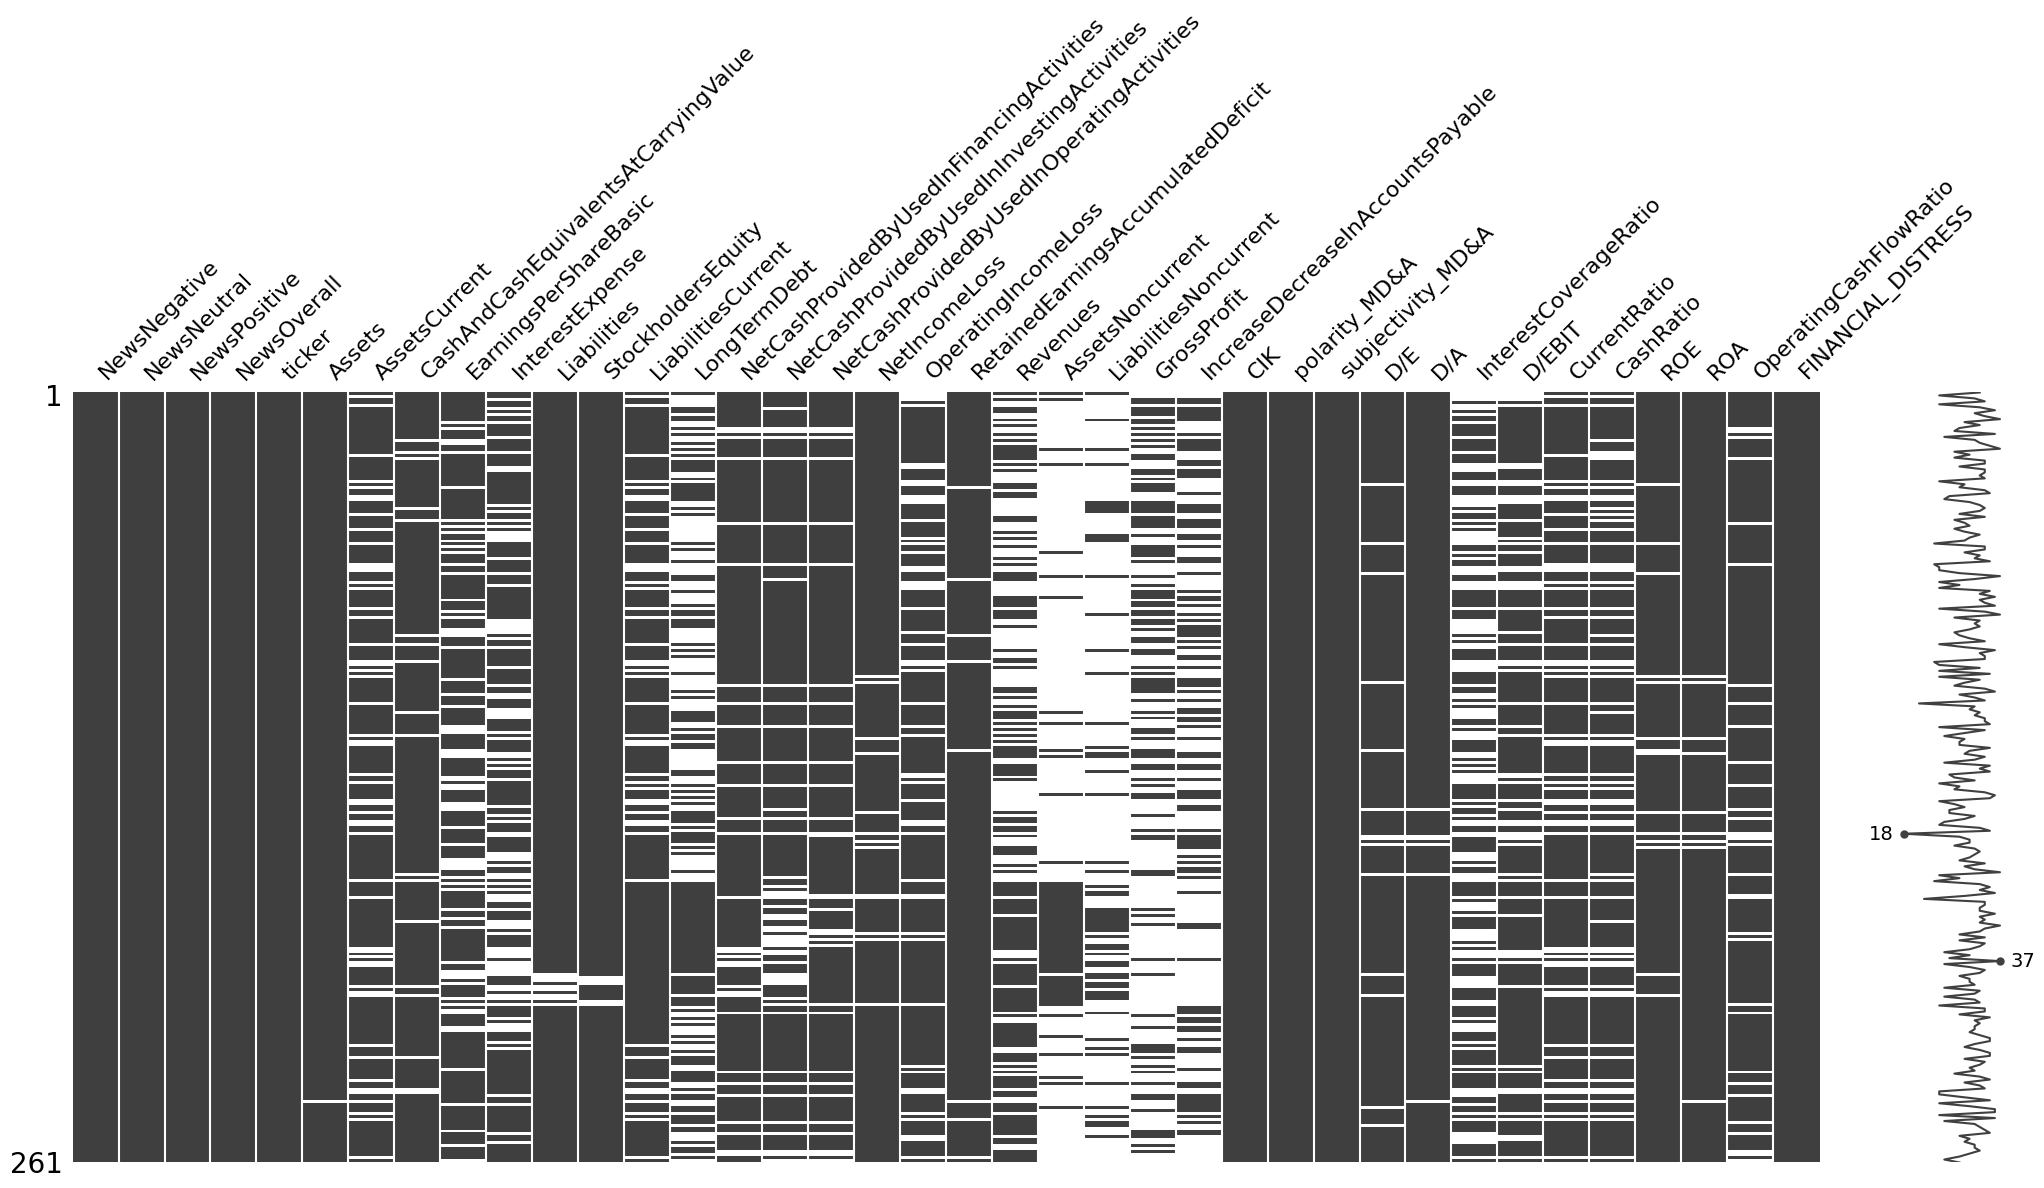

In [10]:
# checking for missing data
msno.matrix(dataset)

In [11]:
# we see that some columns contain too many missing rows
dataset.drop(columns=['AssetsNoncurrent', 'LiabilitiesNoncurrent', 'GrossProfit'], inplace=True)

<Axes: >

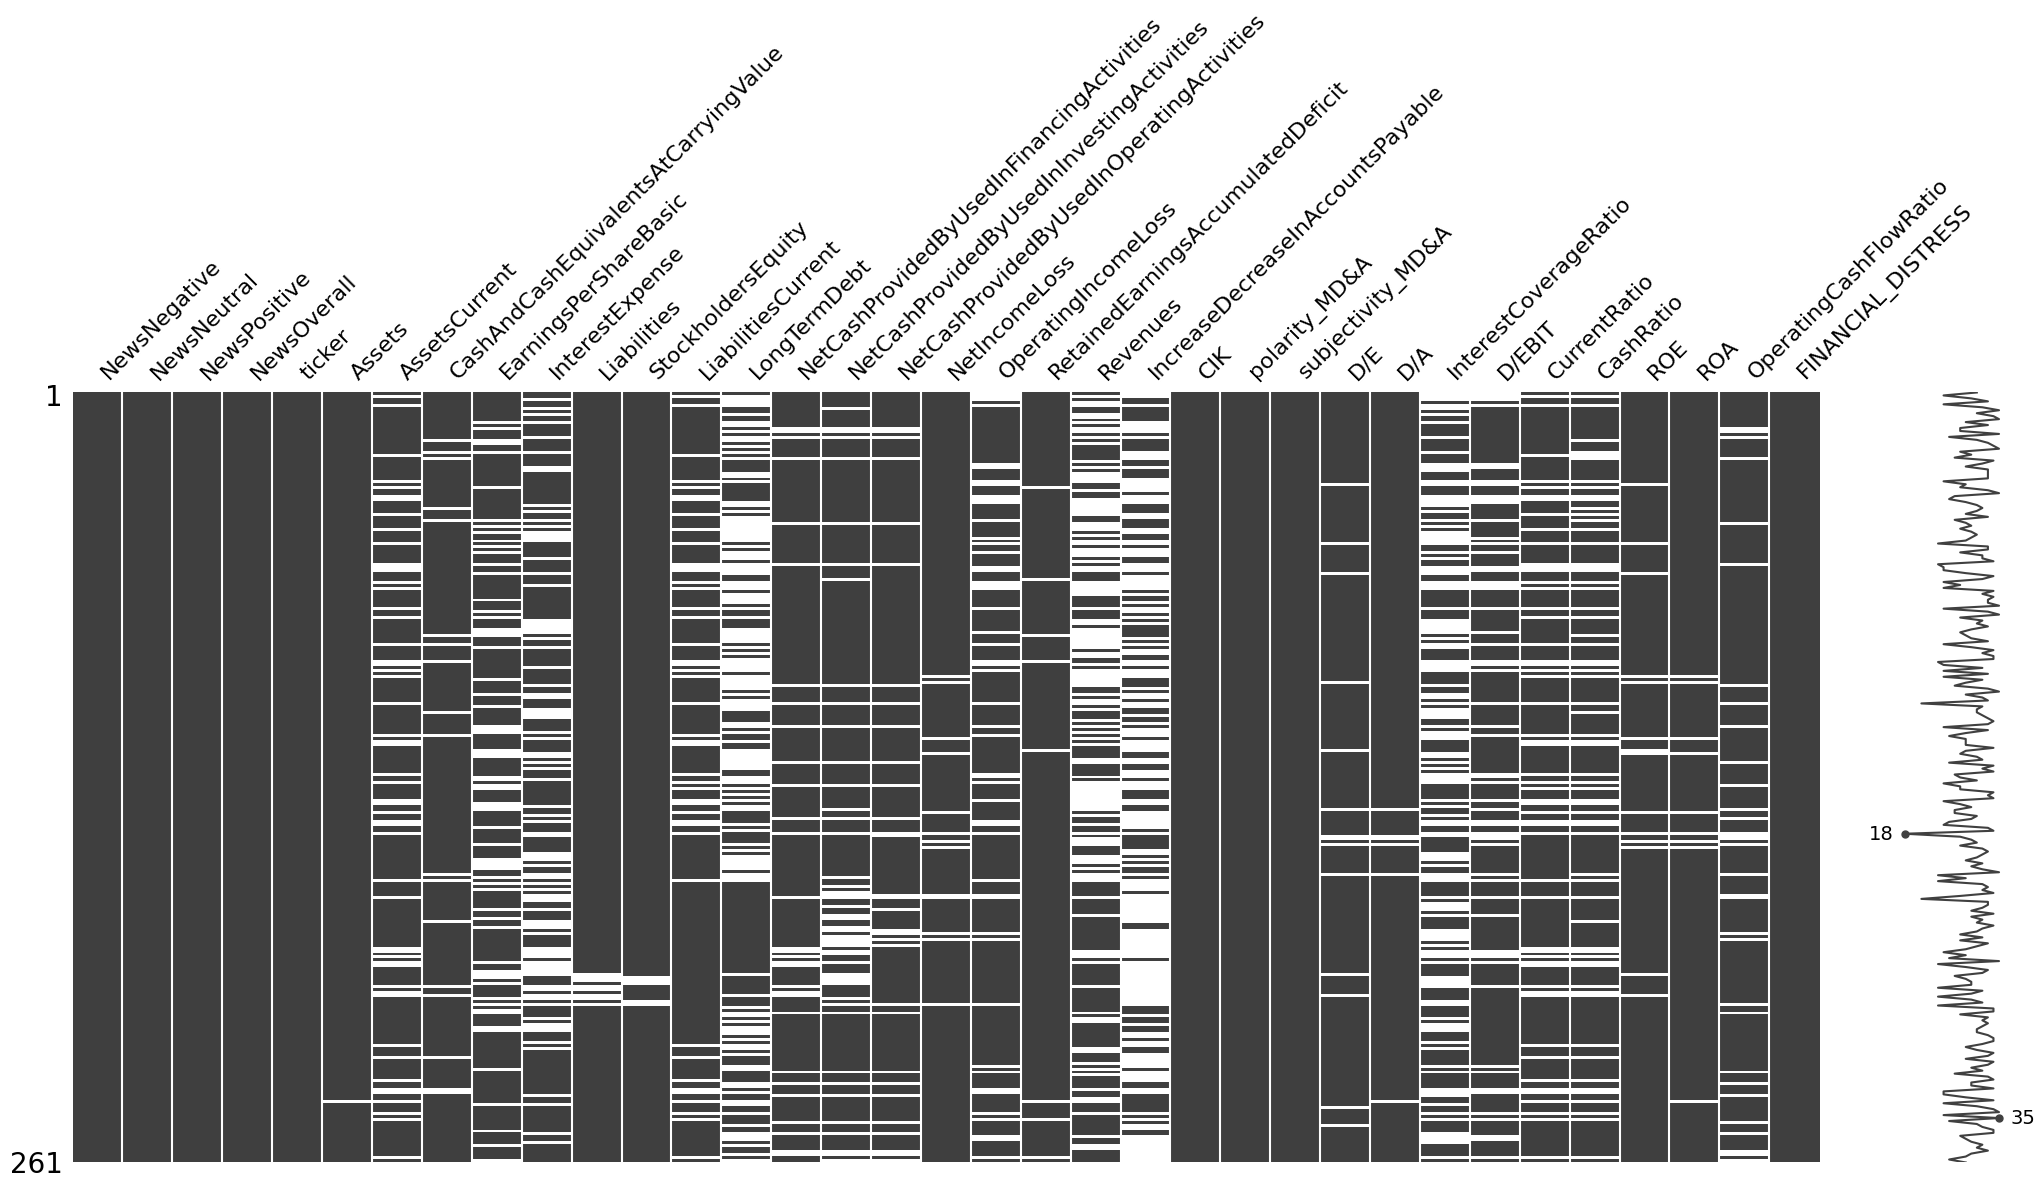

In [12]:
# checking for missing data
msno.matrix(dataset)

In [13]:
# drop non-informational columns
dataset.drop(columns=['ticker', 'CIK', 'NewsNegative', 'NewsPositive', 'NewsNeutral'], inplace=True)

In [14]:
mice_kernel = ImputationKernel(
data = dataset,
save_all_iterations = True,
random_state = 2023
)

In [15]:
mice_kernel.mice(2)
mice_imputation = mice_kernel.complete_data()
mice_imputation.head()

,NewsOverall,Assets,AssetsCurrent,CashAndCashEquivalentsAtCarryingValue,EarningsPerShareBasic,InterestExpense,Liabilities,StockholdersEquity,LiabilitiesCurrent,LongTermDebt,...,D/E,D/A,InterestCoverageRatio,D/EBIT,CurrentRatio,CashRatio,ROE,ROA,OperatingCashFlowRatio,FINANCIAL_DISTRESS
0,0.137935,3.556890e+10,1.257360e+10,3.666400e+09,0.45,161200000.0,2.099760e+10,1.457130e+10,8.229600e+09,7.978500e+09,...,1.441024,0.590336,24.882860,11.605282,1.527851,0.445514,0.032832,0.013450,0.141188,0
1,0.032377,4.823870e+08,3.017150e+08,1.976500e+07,0.64,1002000.0,4.154020e+08,6.698500e+07,4.016810e+08,2.044980e+08,...,6.201418,0.861138,4740.500000,47.921946,0.918362,0.184343,0.012854,0.001785,0.016257,0
2,0.141472,1.719716e+09,8.512340e+08,3.378700e+07,1.62,19964000.0,1.162429e+09,5.572870e+08,3.226270e+08,4.657000e+08,...,2.085871,0.675942,9.084416,19.995984,2.638446,0.104725,0.091605,0.029685,0.237202,0
3,0.147368,3.062080e+08,1.252780e+08,4.085900e+07,0.08,525000.0,7.839600e+07,2.278120e+08,5.980500e+07,1.039120e+08,...,0.344126,0.256022,7.459048,20.019408,2.094775,0.683204,0.009367,0.006969,0.166246,0
4,0.111700,7.954937e+09,1.604100e+09,2.515500e+08,0.56,21878000.0,6.764140e+09,1.190797e+09,1.659228e+09,1.828159e+09,...,5.680347,0.850307,-4.874698,39.100155,0.918362,0.113384,0.076200,0.011407,0.015369,0


In [16]:
dataset = mice_imputation

<Axes: >

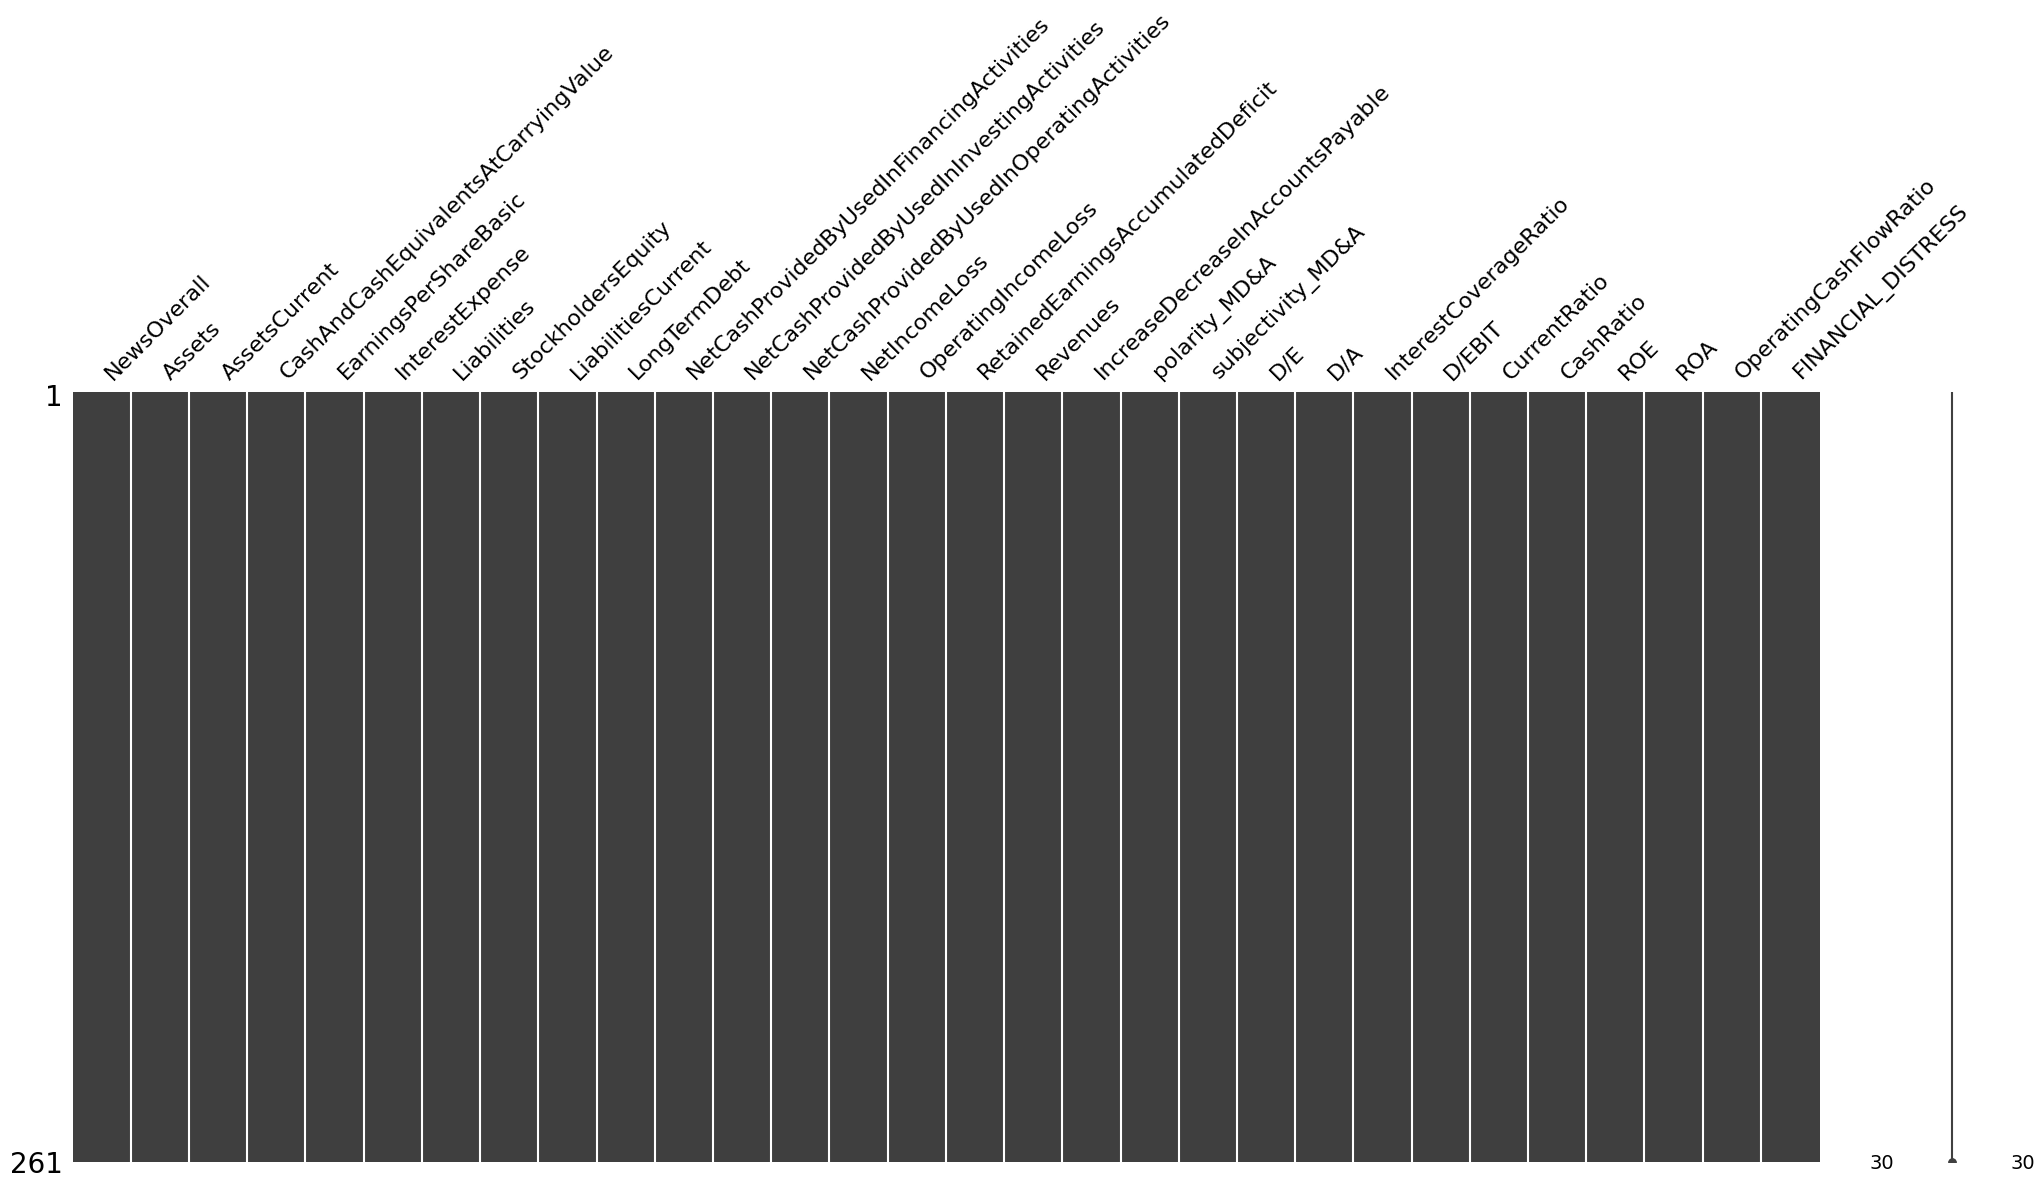

In [17]:
# checking for missing data
msno.matrix(dataset)

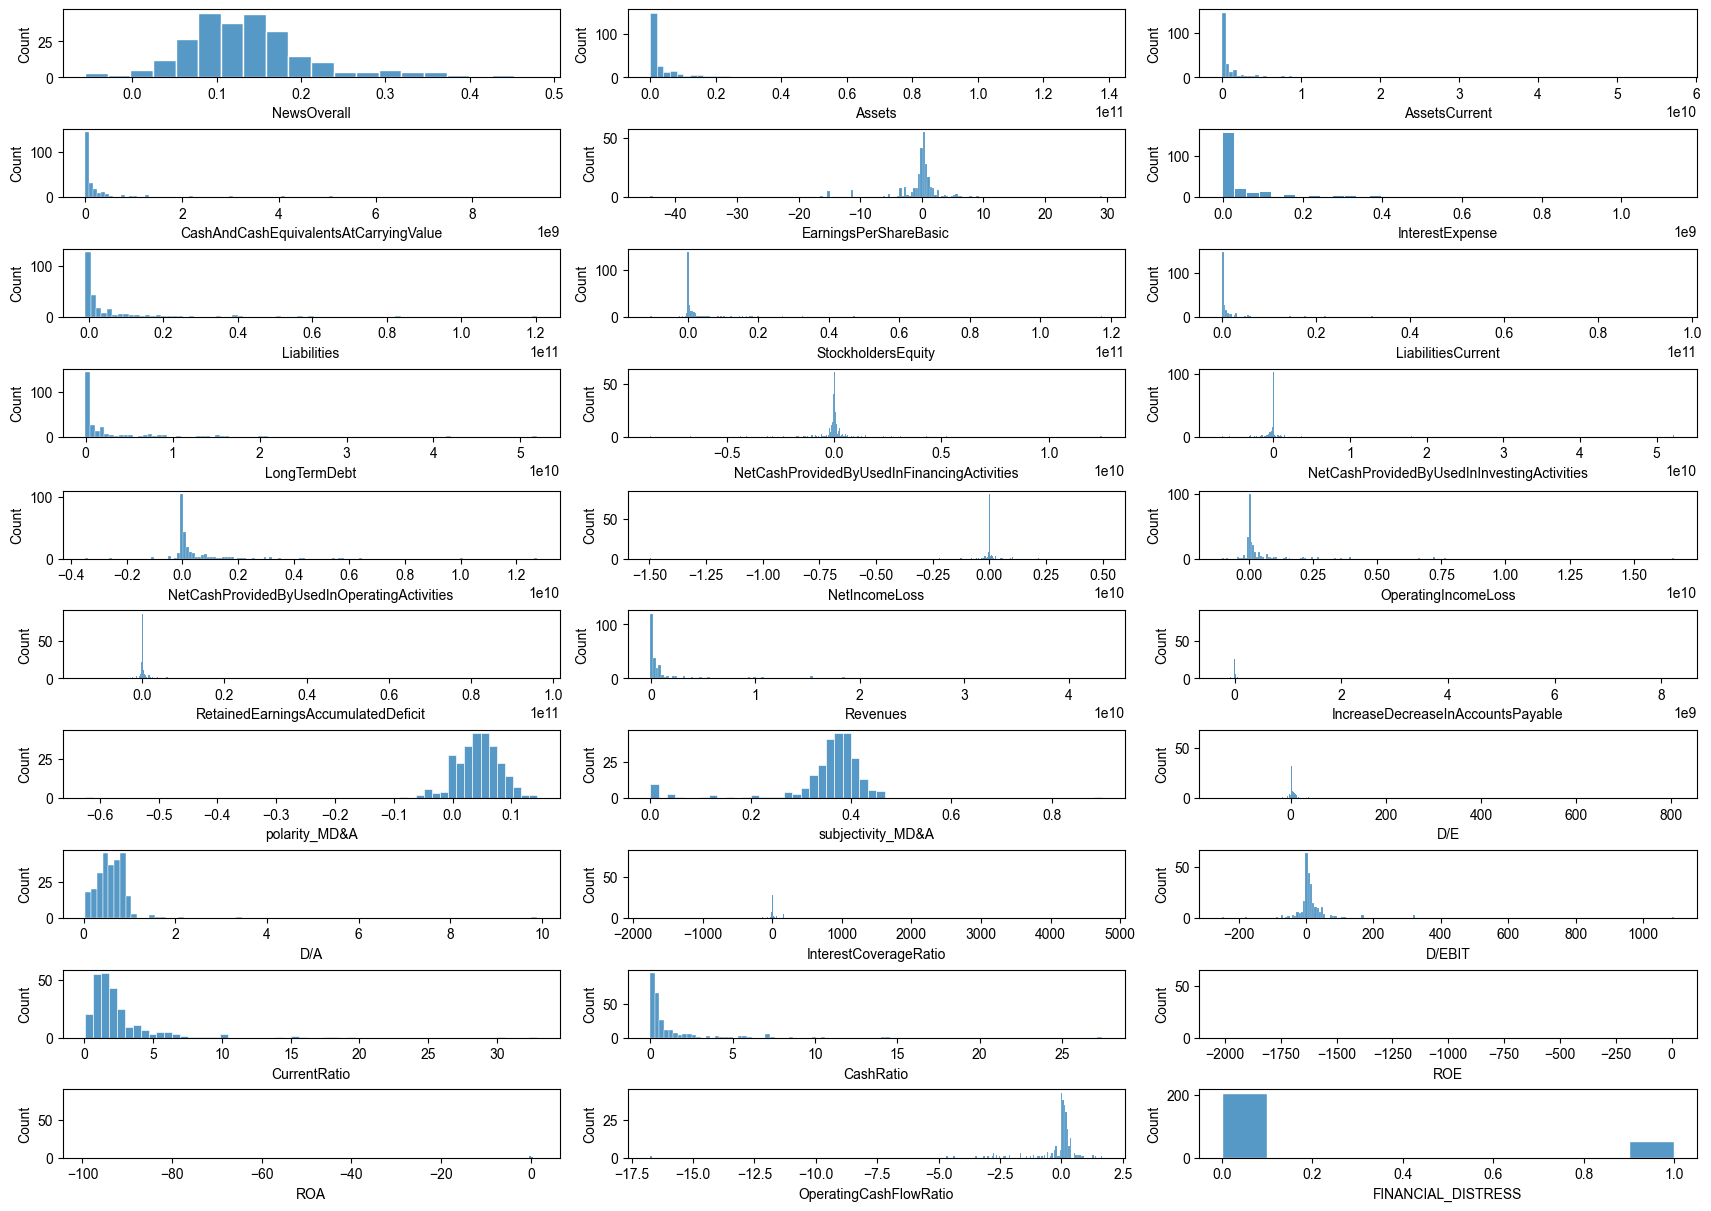

In [18]:
# see the histograms in order to compare with normal distribution
fig, ax = plt.subplots(10,3, figsize=(17,12), constrained_layout=True)
ax=ax.flatten()
sns.set_style("darkgrid")
for num, col in enumerate(dataset.columns):
    sns.histplot(dataset[col], ax=ax[num])
plt.show()

In [19]:
dataset.replace([np.inf, -np.inf], 0, inplace=True)

<Axes: >

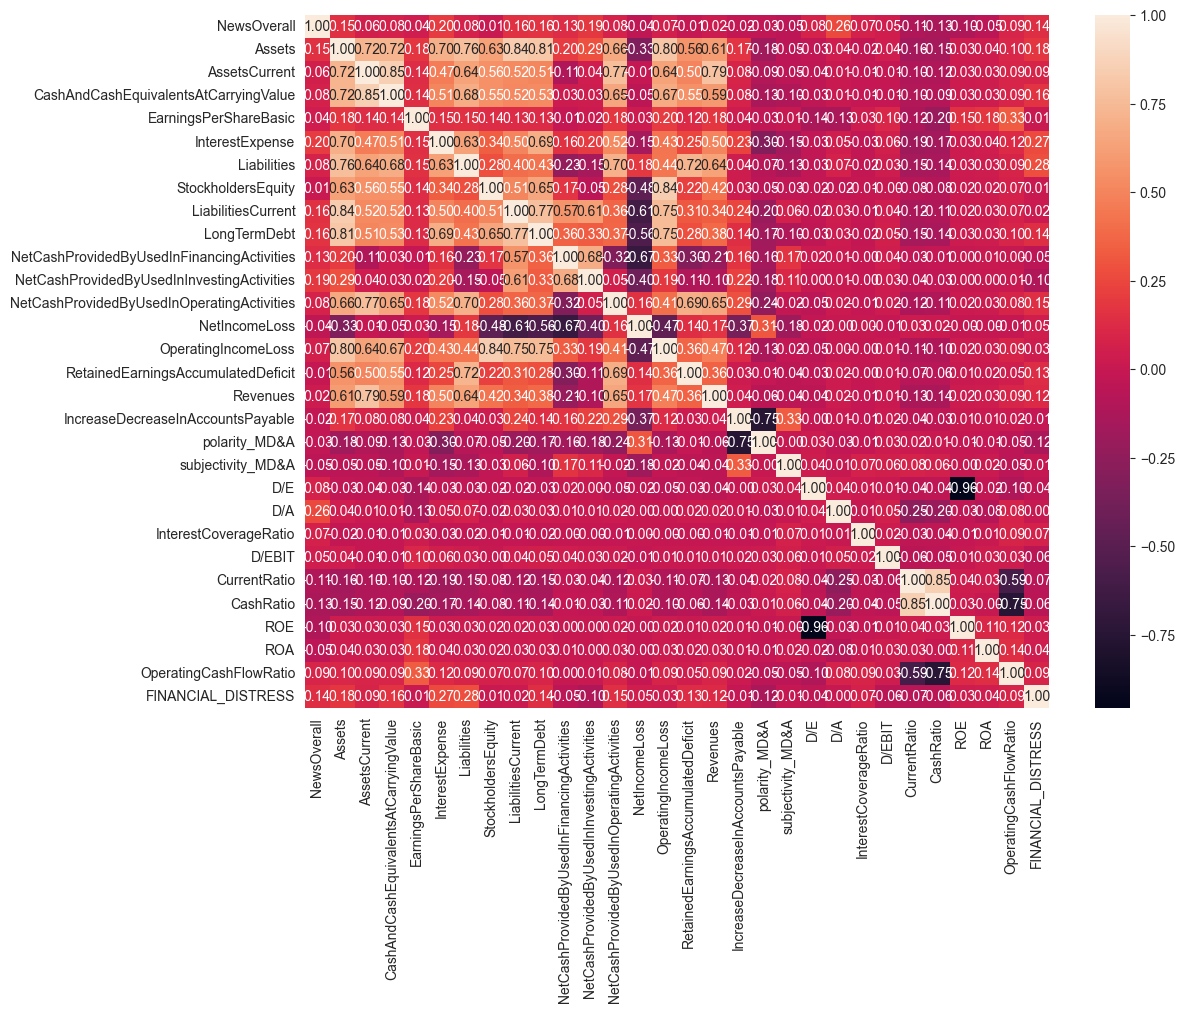

In [20]:
plt.figure(figsize=(12,9))
sns.heatmap(dataset.corr(), annot=True, fmt='.2f')

In [21]:
# correlation
corr=dataset.corr()
corr['FINANCIAL_DISTRESS']
correlation_df=pd.Series(corr['FINANCIAL_DISTRESS']).to_frame()
correlation_df.sort_values(by='FINANCIAL_DISTRESS',ascending=False)

,FINANCIAL_DISTRESS
FINANCIAL_DISTRESS,1.000000
Liabilities,0.277059
InterestExpense,0.266150
Assets,0.175266
CashAndCashEquivalentsAtCarryingValue,0.162800
NetCashProvidedByUsedInOperatingActivities,0.150291
LongTermDebt,0.142419
NewsOverall,0.142038
RetainedEarningsAccumulatedDeficit,0.130251
Revenues,0.115916


In [22]:
# we should also check data for multicollinearity
## VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = dataset.drop('FINANCIAL_DISTRESS', axis=1).columns
  
### calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(dataset.drop('FINANCIAL_DISTRESS', axis=1).values, i)
                          for i in range(len(dataset.drop('FINANCIAL_DISTRESS', axis=1).columns))]

In [23]:
vif_data

,feature,VIF
0,NewsOverall,4.260555
1,Assets,68.244592
2,AssetsCurrent,15.119251
3,CashAndCashEquivalentsAtCarryingValue,8.399984
4,EarningsPerShareBasic,1.359781
5,InterestExpense,7.428417
6,Liabilities,28.526701
7,StockholdersEquity,10.040085
8,LiabilitiesCurrent,22.932798
9,LongTermDebt,10.315717


In [24]:
# basically we see, that for several features VIF is higher than 8-10, so some of them should be eliminated
dataset.drop('Assets', axis = 1, inplace=True)

In [25]:
# restate VIF test
vif_data = pd.DataFrame()
vif_data["feature"] = dataset.drop('FINANCIAL_DISTRESS', axis=1).columns
vif_data["VIF"] = [variance_inflation_factor(dataset.drop('FINANCIAL_DISTRESS', axis=1).values, i)
                          for i in range(len(dataset.drop('FINANCIAL_DISTRESS', axis=1).columns))]

In [26]:
vif_data

,feature,VIF
0,NewsOverall,4.212318
1,AssetsCurrent,14.714454
2,CashAndCashEquivalentsAtCarryingValue,8.182362
3,EarningsPerShareBasic,1.335809
4,InterestExpense,7.129815
5,Liabilities,10.336232
6,StockholdersEquity,7.204240
7,LiabilitiesCurrent,14.680469
8,LongTermDebt,8.073529
9,NetCashProvidedByUsedInFinancingActivities,6.308343


In [27]:
# basically we see, that for several features VIF is higher than 8-10, so some of them should be eliminated
dataset.drop(columns=['AssetsCurrent', 'LiabilitiesCurrent'], axis = 1, inplace=True)

In [28]:
# restate VIF test
vif_data = pd.DataFrame()
vif_data["feature"] = dataset.drop('FINANCIAL_DISTRESS', axis=1).columns
vif_data["VIF"] = [variance_inflation_factor(dataset.drop('FINANCIAL_DISTRESS', axis=1).values, i)
                          for i in range(len(dataset.drop('FINANCIAL_DISTRESS', axis=1).columns))]

In [29]:
vif_data

,feature,VIF
0,NewsOverall,4.203703
1,CashAndCashEquivalentsAtCarryingValue,4.117029
2,EarningsPerShareBasic,1.311595
3,InterestExpense,6.648247
4,Liabilities,8.033960
5,StockholdersEquity,7.015075
6,LongTermDebt,7.883896
7,NetCashProvidedByUsedInFinancingActivities,6.243631
8,NetCashProvidedByUsedInInvestingActivities,3.858614
9,NetCashProvidedByUsedInOperatingActivities,7.648560


In [30]:
# basically we see, that for several features VIF is higher than 8-10, so some of them should be eliminated
dataset.drop(columns=['ROE'], axis = 1, inplace=True)

In [31]:
# restate VIF test
vif_data = pd.DataFrame()
vif_data["feature"] = dataset.drop('FINANCIAL_DISTRESS', axis=1).columns
vif_data["VIF"] = [variance_inflation_factor(dataset.drop('FINANCIAL_DISTRESS', axis=1).values, i)
                          for i in range(len(dataset.drop('FINANCIAL_DISTRESS', axis=1).columns))]

In [32]:
vif_data

,feature,VIF
0,NewsOverall,4.147601
1,CashAndCashEquivalentsAtCarryingValue,4.079042
2,EarningsPerShareBasic,1.303715
3,InterestExpense,6.648238
4,Liabilities,7.927180
5,StockholdersEquity,6.838234
6,LongTermDebt,7.876176
7,NetCashProvidedByUsedInFinancingActivities,6.236642
8,NetCashProvidedByUsedInInvestingActivities,3.842433
9,NetCashProvidedByUsedInOperatingActivities,7.621791


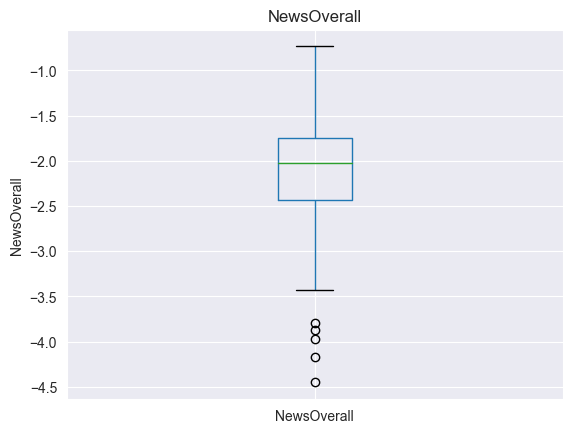

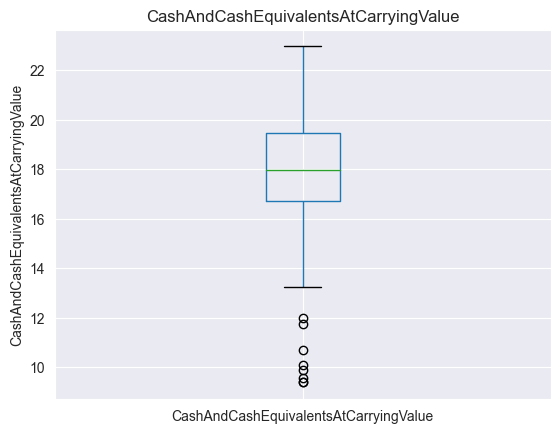

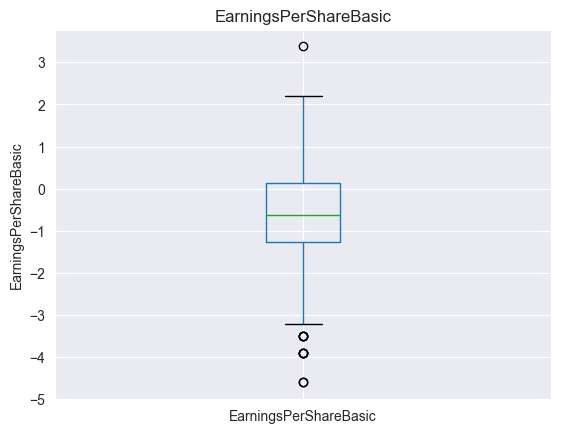

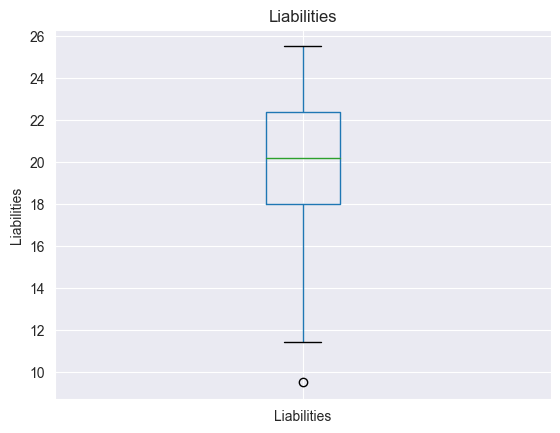

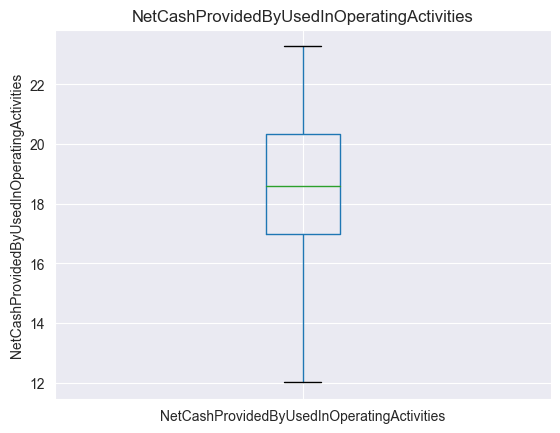

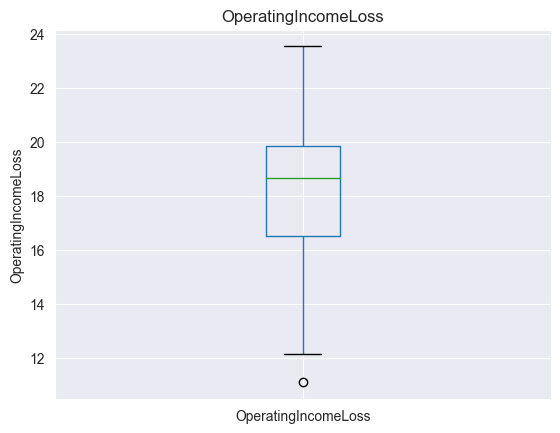

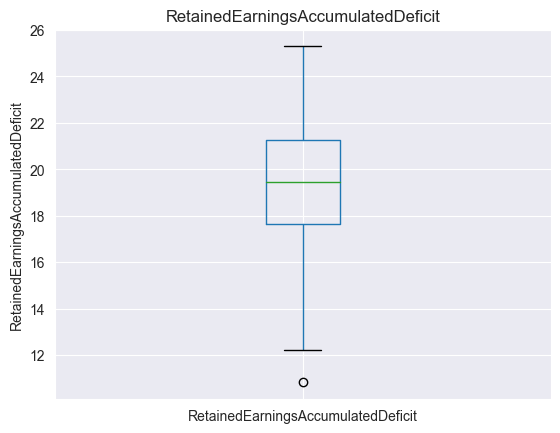

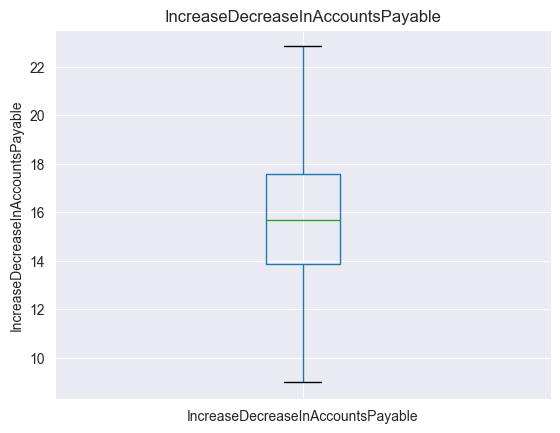

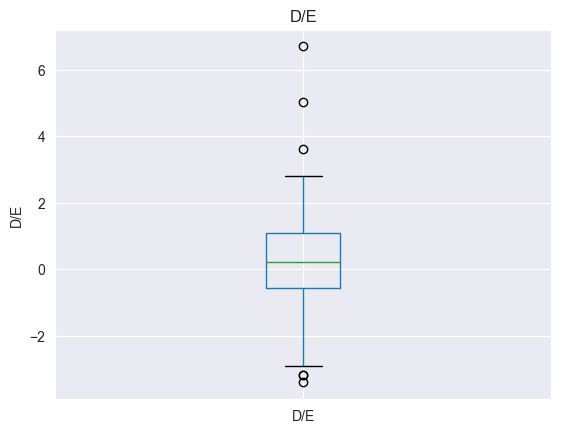

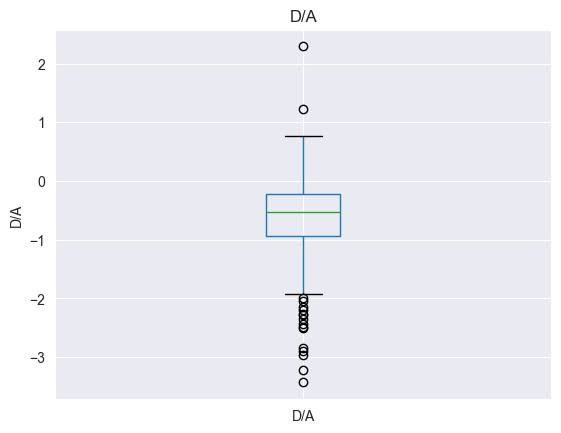

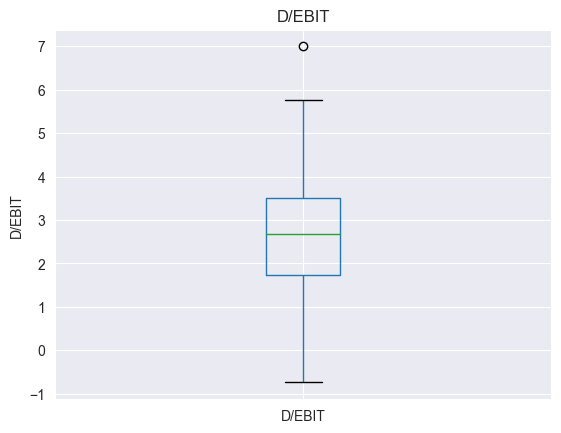

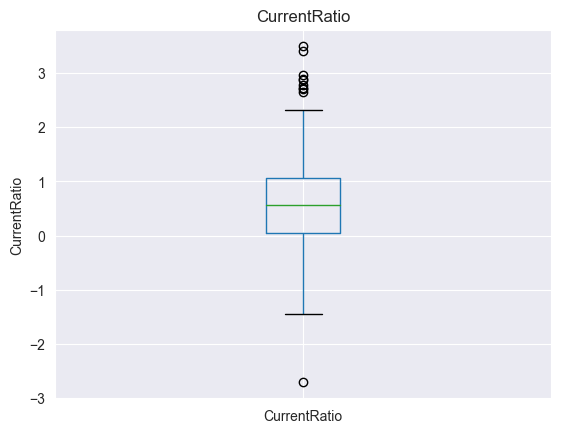

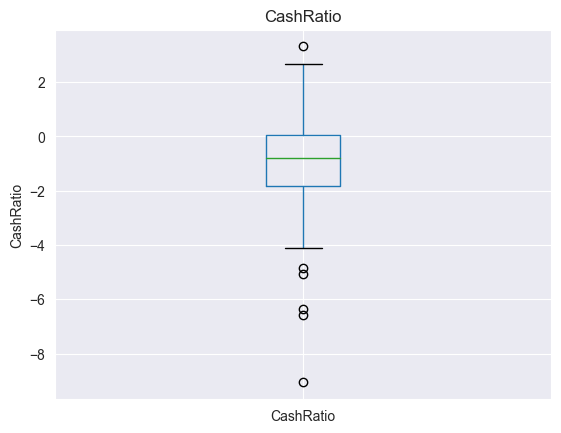

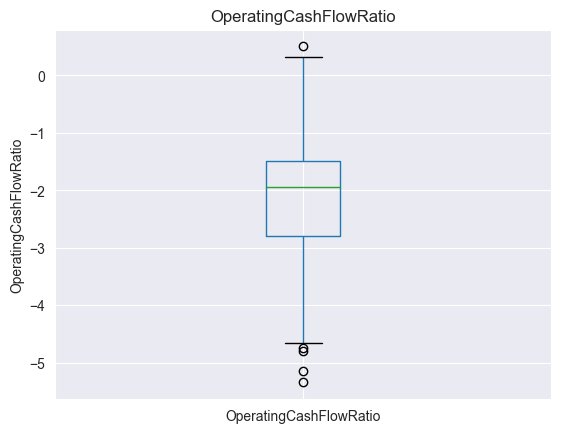

In [33]:
# outliers detection through boxplots
for feature in dataset:
    data= dataset.copy()
    if 0 in data[feature].unique():
        pass
    else:
        data[feature]=np.log(data[feature])
        data.boxplot(column=feature)
        plt.ylabel(feature)
        plt.title(feature)
        plt.show()

In [34]:
dataset[['NewsOverall','polarity_MD&A', 'D/A', 'D/E', 'FINANCIAL_DISTRESS', 'ROA', 'CurrentRatio']].describe()

,NewsOverall,polarity_MD&A,D/A,D/E,FINANCIAL_DISTRESS,ROA,CurrentRatio
count,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000
mean,0.142138,0.040180,0.642058,5.102419,0.203065,-0.503804,2.887721
std,0.084828,0.055081,0.670471,51.626317,0.403053,6.194387,3.901327
min,-0.056049,-0.625000,0.032287,-144.156863,0.000000,-99.404944,0.066140
25%,0.085686,0.020238,0.393278,0.408241,0.000000,-0.036013,1.056877
50%,0.131065,0.043756,0.592058,1.066908,0.000000,0.006271,1.771846
75%,0.172995,0.064867,0.799667,2.782411,0.000000,0.020348,2.902645
max,0.479798,0.143810,9.887556,805.679785,1.000000,1.394768,32.905304


In [35]:
X = dataset.drop('FINANCIAL_DISTRESS',axis=1)
y = dataset['FINANCIAL_DISTRESS']

<Axes: xlabel='FINANCIAL_DISTRESS', ylabel='count'>

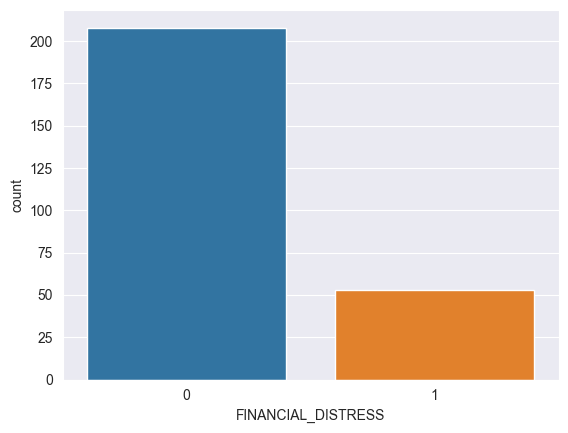

In [36]:
sns.countplot(y)

In [37]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [38]:
oversample = SMOTE()
X,y=oversample.fit_resample(X,y)

<Axes: xlabel='FINANCIAL_DISTRESS', ylabel='count'>

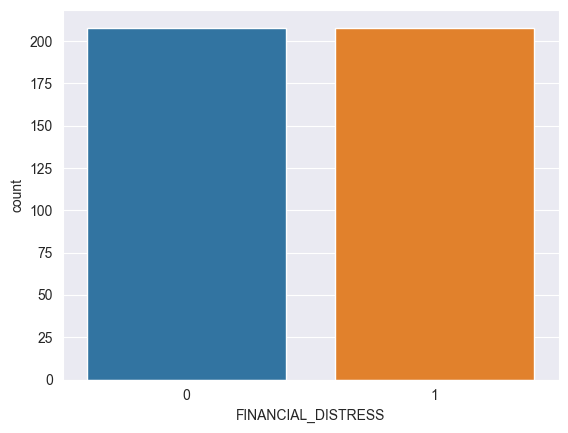

In [39]:
sns.countplot(y)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

In [41]:
def print_evaluate(true, predicted):
    accuracy=np.round(accuracy_score(true, predicted),3)
    precision=np.round(precision_score(true, predicted),3)
    recall=np.round(recall_score(true, predicted),3)
    f1=np.round(f1_score(true, predicted),3)
    balanced_accuracy=np.round(balanced_accuracy_score(true, predicted),3)
    roc_auc = np.round(roc_auc_score(true, predicted),3)
    print('accuracy: ', accuracy)
    print('precision: ', precision)
    print('recall: ', recall)
    print('f1:', f1)
    print('balanced accuracy:', balanced_accuracy)
    print('roc_auc:', roc_auc)

def cross_val(model, X, y):
    pred=cross_val_score(model, X,y,cv=5)
    return np.round(pred.mean(),3)

def evaluate(true, predicted):
    accuracy=np.round(accuracy_score(true, predicted),3)
    precision=np.round(precision_score(true, predicted),3)
    recall=np.round(recall_score(true, predicted),3)
    f1=np.round(f1_score(true, predicted),3)
    balanced_accuracy=np.round(balanced_accuracy_score(true, predicted),3)
    roc_auc = np.round(roc_auc_score(true, predicted),3)
    
    return accuracy, precision, recall, f1, balanced_accuracy, roc_auc

In [46]:
log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)

LogisticRegression()

In [55]:
train_pred = log_reg.predict(X_train)

print('Train set evaluation:\n')
print_evaluate(y_train, train_pred)
print('--------------------------------\n')
cross_score=cross_val(log_reg, X_train, y_train)
print('Cross_validation score:\n')
cross_score

Train set evaluation:

accuracy:  0.699
precision:  0.743
recall:  0.631
f1: 0.682
balanced accuracy: 0.7
roc_auc: 0.7
--------------------------------

Cross_validation score:



0.666

In [56]:
results_df=pd.DataFrame(data=[['Logistic Regression', *evaluate(y_train, train_pred), cross_score]], columns=['Model', 'accuracy', 'precision', 'recall', 'f1', 'balanced_accuracy', 'roc_auc', 'cross_score'])
results_df

,Model,accuracy,precision,recall,f1,balanced_accuracy,roc_auc,cross_score
0,Logistic Regression,0.699,0.743,0.631,0.682,0.7,0.7,0.666


In [57]:
lasso = LogisticRegression(penalty='l1', solver='liblinear')
lasso.fit(X_train,y_train)

LogisticRegression(penalty='l1', solver='liblinear')

In [58]:
train_pred = lasso.predict(X_train)

print('Train set evaluation:\n')
print_evaluate(y_train, train_pred)
print('--------------------------------\n')
cross_score=cross_val(lasso, X_train, y_train)
print('Cross_validation score:\n')
cross_score

Train set evaluation:

accuracy:  0.67
precision:  0.744
recall:  0.544
f1: 0.628
balanced accuracy: 0.673
roc_auc: 0.673
--------------------------------

Cross_validation score:



0.634

In [59]:
results_df=results_df.append(pd.DataFrame(data=[['Lasso', *evaluate(y_train, train_pred), cross_score]], columns=['Model', 'accuracy', 'precision', 'recall', 'f1', 'balanced_accuracy', 'roc_auc', 'cross_score']))
results_df

,Model,accuracy,precision,recall,f1,balanced_accuracy,roc_auc,cross_score
0,Logistic Regression,0.699,0.743,0.631,0.682,0.700,0.700,0.666
0,Lasso,0.670,0.744,0.544,0.628,0.673,0.673,0.634


In [60]:
ridge = LogisticRegression(penalty='l2')
ridge.fit(X_train,y_train)

LogisticRegression()

In [61]:
train_pred = ridge.predict(X_train)

print('Train set evaluation:\n')
print_evaluate(y_train, train_pred)
print('--------------------------------\n')
cross_score=cross_val(ridge, X_train, y_train)
print('Cross_validation score:\n')
cross_score

Train set evaluation:

accuracy:  0.699
precision:  0.743
recall:  0.631
f1: 0.682
balanced accuracy: 0.7
roc_auc: 0.7
--------------------------------

Cross_validation score:



0.666

In [62]:
results_df=results_df.append(pd.DataFrame(data=[['Ridge', *evaluate(y_train, train_pred), cross_score]], columns=['Model', 'accuracy', 'precision', 'recall', 'f1', 'balanced_accuracy', 'roc_auc', 'cross_score']))
results_df

,Model,accuracy,precision,recall,f1,balanced_accuracy,roc_auc,cross_score
0,Logistic Regression,0.699,0.743,0.631,0.682,0.700,0.700,0.666
0,Lasso,0.670,0.744,0.544,0.628,0.673,0.673,0.634
0,Ridge,0.699,0.743,0.631,0.682,0.700,0.700,0.666


In [63]:
svc = SVC()
svc.fit(X_train,y_train)

SVC()

In [64]:
train_pred = svc.predict(X_train)

print('Train set evaluation:\n')
print_evaluate(y_train, train_pred)
print('--------------------------------\n')
cross_score=cross_val(svc, X_train, y_train)
print('Cross_validation score:\n')
cross_score

Train set evaluation:

accuracy:  0.676
precision:  0.757
recall:  0.544
f1: 0.633
balanced accuracy: 0.68
roc_auc: 0.68
--------------------------------

Cross_validation score:



0.641

In [65]:
results_df=results_df.append(pd.DataFrame(data=[['Support Vector Machines', *evaluate(y_train, train_pred), cross_score]], columns=['Model', 'accuracy', 'precision', 'recall', 'f1', 'balanced_accuracy', 'roc_auc', 'cross_score']))
results_df

,Model,accuracy,precision,recall,f1,balanced_accuracy,roc_auc,cross_score
0,Logistic Regression,0.699,0.743,0.631,0.682,0.700,0.700,0.666
0,Lasso,0.670,0.744,0.544,0.628,0.673,0.673,0.634
0,Ridge,0.699,0.743,0.631,0.682,0.700,0.700,0.666
0,Support Vector Machines,0.676,0.757,0.544,0.633,0.680,0.680,0.641


In [66]:
# test another classification algorithms
rfr = RandomForestClassifier()
rfr.fit(X_train,y_train)

RandomForestClassifier()

In [67]:
train_pred = rfr.predict(X_train)

print('Train set evaluation:\n')
print_evaluate(y_train, train_pred)
print('--------------------------------\n')
cross_score=cross_val(rfr, X_train, y_train)
print('Cross_validation score:\n')
cross_score

Train set evaluation:

accuracy:  1.0
precision:  1.0
recall:  1.0
f1: 1.0
balanced accuracy: 1.0
roc_auc: 1.0
--------------------------------

Cross_validation score:



0.878

In [68]:
results_df=results_df.append(pd.DataFrame(data=[['Random Forest', *evaluate(y_train, train_pred), cross_score]], columns=['Model', 'accuracy', 'precision', 'recall', 'f1', 'balanced_accuracy', 'roc_auc', 'cross_score']))
results_df

,Model,accuracy,precision,recall,f1,balanced_accuracy,roc_auc,cross_score
0,Logistic Regression,0.699,0.743,0.631,0.682,0.700,0.700,0.666
0,Lasso,0.670,0.744,0.544,0.628,0.673,0.673,0.634
0,Ridge,0.699,0.743,0.631,0.682,0.700,0.700,0.666
0,Support Vector Machines,0.676,0.757,0.544,0.633,0.680,0.680,0.641
0,Random Forest,1.000,1.000,1.000,1.000,1.000,1.000,0.878


In [69]:
# test another classification algorithms
knears = KNeighborsClassifier()
knears.fit(X_train,y_train)

KNeighborsClassifier()

In [70]:
train_pred = knears.predict(X_train)

print('Train set evaluation:\n')
print_evaluate(y_train, train_pred)
print('--------------------------------\n')
cross_score=cross_val(knears, X_train, y_train)
print('Cross_validation score:\n')
cross_score

Train set evaluation:

accuracy:  0.859
precision:  0.787
recall:  0.994
f1: 0.878
balanced accuracy: 0.855
roc_auc: 0.855
--------------------------------

Cross_validation score:



0.734

In [71]:
results_df=results_df.append(pd.DataFrame(data=[['KNearest Neighbours', *evaluate(y_train, train_pred), cross_score]], columns=['Model', 'accuracy', 'precision', 'recall', 'f1', 'balanced_accuracy', 'roc_auc', 'cross_score']))
results_df

,Model,accuracy,precision,recall,f1,balanced_accuracy,roc_auc,cross_score
0,Logistic Regression,0.699,0.743,0.631,0.682,0.700,0.700,0.666
0,Lasso,0.670,0.744,0.544,0.628,0.673,0.673,0.634
0,Ridge,0.699,0.743,0.631,0.682,0.700,0.700,0.666
0,Support Vector Machines,0.676,0.757,0.544,0.633,0.680,0.680,0.641
0,Random Forest,1.000,1.000,1.000,1.000,1.000,1.000,0.878
0,KNearest Neighbours,0.859,0.787,0.994,0.878,0.855,0.855,0.734


In [72]:
# test another classification algorithms
ab = AdaBoostClassifier()
ab.fit(X_train,y_train)

AdaBoostClassifier()

In [73]:
# predict target and make cross-validation
train_pred = ab.predict(X_train)

print('Train set evaluation:\n')
print_evaluate(y_train, train_pred)
print('--------------------------------\n')
cross_score=cross_val(ab, X_train, y_train)
print('Cross_validation score:\n')
cross_score

Train set evaluation:

accuracy:  0.987
precision:  0.988
recall:  0.988
f1: 0.988
balanced accuracy: 0.987
roc_auc: 0.987
--------------------------------

Cross_validation score:



0.798

In [74]:
results_df=results_df.append(pd.DataFrame(data=[['Ada Boost', *evaluate(y_train, train_pred), cross_score]], columns=['Model', 'accuracy', 'precision', 'recall', 'f1', 'balanced_accuracy', 'roc_auc', 'cross_score']))
results_df

,Model,accuracy,precision,recall,f1,balanced_accuracy,roc_auc,cross_score
0,Logistic Regression,0.699,0.743,0.631,0.682,0.700,0.700,0.666
0,Lasso,0.670,0.744,0.544,0.628,0.673,0.673,0.634
0,Ridge,0.699,0.743,0.631,0.682,0.700,0.700,0.666
0,Support Vector Machines,0.676,0.757,0.544,0.633,0.680,0.680,0.641
0,Random Forest,1.000,1.000,1.000,1.000,1.000,1.000,0.878
0,KNearest Neighbours,0.859,0.787,0.994,0.878,0.855,0.855,0.734
0,Ada Boost,0.987,0.988,0.988,0.988,0.987,0.987,0.798


In [75]:
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)

DecisionTreeClassifier()

In [76]:
# predict target and make cross-validation

train_pred = dt.predict(X_train)

print('Train set evaluation:\n')
print_evaluate(y_train, train_pred)
print('--------------------------------\n')
cross_score=cross_val(dt, X_train, y_train)
print('Cross_validation score:\n')
cross_score

Train set evaluation:

accuracy:  1.0
precision:  1.0
recall:  1.0
f1: 1.0
balanced accuracy: 1.0
roc_auc: 1.0
--------------------------------

Cross_validation score:



0.74

In [77]:
results_df=results_df.append(pd.DataFrame(data=[['Decision Tree', *evaluate(y_train, train_pred), cross_score]], columns=['Model', 'accuracy', 'precision', 'recall', 'f1', 'balanced_accuracy', 'roc_auc', 'cross_score']))
results_df

,Model,accuracy,precision,recall,f1,balanced_accuracy,roc_auc,cross_score
0,Logistic Regression,0.699,0.743,0.631,0.682,0.700,0.700,0.666
0,Lasso,0.670,0.744,0.544,0.628,0.673,0.673,0.634
0,Ridge,0.699,0.743,0.631,0.682,0.700,0.700,0.666
0,Support Vector Machines,0.676,0.757,0.544,0.633,0.680,0.680,0.641
0,Random Forest,1.000,1.000,1.000,1.000,1.000,1.000,0.878
0,KNearest Neighbours,0.859,0.787,0.994,0.878,0.855,0.855,0.734
0,Ada Boost,0.987,0.988,0.988,0.988,0.987,0.987,0.798
0,Decision Tree,1.000,1.000,1.000,1.000,1.000,1.000,0.740


In [78]:
cb = CatBoostClassifier(silent=True)
cb.fit(X_train,y_train)

In [79]:
# predict target and make cross-validation

train_pred = cb.predict(X_train)

print('Train set evaluation:\n')
print_evaluate(y_train, train_pred)
print('--------------------------------\n')
cross_score=cross_val(cb, X_train, y_train)
print('Cross_validation score:\n')
cross_score

Train set evaluation:

accuracy:  1.0
precision:  1.0
recall:  1.0
f1: 1.0
balanced accuracy: 1.0
roc_auc: 1.0
--------------------------------

Cross_validation score:



0.894

In [80]:
results_df=results_df.append(pd.DataFrame(data=[['Cat Boost', *evaluate(y_train, train_pred), cross_score]], columns=['Model', 'accuracy', 'precision', 'recall', 'f1', 'balanced_accuracy', 'roc_auc', 'cross_score']))
results_df

,Model,accuracy,precision,recall,f1,balanced_accuracy,roc_auc,cross_score
0,Logistic Regression,0.699,0.743,0.631,0.682,0.700,0.700,0.666
0,Lasso,0.670,0.744,0.544,0.628,0.673,0.673,0.634
0,Ridge,0.699,0.743,0.631,0.682,0.700,0.700,0.666
0,Support Vector Machines,0.676,0.757,0.544,0.633,0.680,0.680,0.641
0,Random Forest,1.000,1.000,1.000,1.000,1.000,1.000,0.878
0,KNearest Neighbours,0.859,0.787,0.994,0.878,0.855,0.855,0.734
0,Ada Boost,0.987,0.988,0.988,0.988,0.987,0.987,0.798
0,Decision Tree,1.000,1.000,1.000,1.000,1.000,1.000,0.740
0,Cat Boost,1.000,1.000,1.000,1.000,1.000,1.000,0.894


In [81]:
xb = xgb.XGBClassifier().fit(X_train, y_train)

In [82]:
# predict target and make cross-validation

train_pred = xb.predict(X_train)

print('Train set evaluation:\n')
print_evaluate(y_train, train_pred)
print('--------------------------------\n')
cross_score=cross_val(xb, X_train, y_train)
print('Cross_validation score:\n')
cross_score

Train set evaluation:

accuracy:  1.0
precision:  1.0
recall:  1.0
f1: 1.0
balanced accuracy: 1.0
roc_auc: 1.0
--------------------------------

Cross_validation score:



0.84

In [83]:
results_df=results_df.append(pd.DataFrame(data=[['XG Boost', *evaluate(y_train, train_pred), cross_score]], columns=['Model', 'accuracy', 'precision', 'recall', 'f1', 'balanced_accuracy', 'roc_auc', 'cross_score']))
results_df

,Model,accuracy,precision,recall,f1,balanced_accuracy,roc_auc,cross_score
0,Logistic Regression,0.699,0.743,0.631,0.682,0.700,0.700,0.666
0,Lasso,0.670,0.744,0.544,0.628,0.673,0.673,0.634
0,Ridge,0.699,0.743,0.631,0.682,0.700,0.700,0.666
0,Support Vector Machines,0.676,0.757,0.544,0.633,0.680,0.680,0.641
0,Random Forest,1.000,1.000,1.000,1.000,1.000,1.000,0.878
0,KNearest Neighbours,0.859,0.787,0.994,0.878,0.855,0.855,0.734
0,Ada Boost,0.987,0.988,0.988,0.988,0.987,0.987,0.798
0,Decision Tree,1.000,1.000,1.000,1.000,1.000,1.000,0.740
0,Cat Boost,1.000,1.000,1.000,1.000,1.000,1.000,0.894
0,XG Boost,1.000,1.000,1.000,1.000,1.000,1.000,0.840


In [84]:
lb = lgb.LGBMClassifier().fit(X_train, y_train)

In [85]:
# predict target and make cross-validation

train_pred = lb.predict(X_train)

print('Train set evaluation:\n')
print_evaluate(y_train, train_pred)
print('--------------------------------\n')
cross_score=cross_val(lb, X_train, y_train)
print('Cross_validation score:\n')
cross_score

Train set evaluation:

accuracy:  1.0
precision:  1.0
recall:  1.0
f1: 1.0
balanced accuracy: 1.0
roc_auc: 1.0
--------------------------------

Cross_validation score:



0.862

In [86]:
results_df=results_df.append(pd.DataFrame(data=[['Light GBM', *evaluate(y_train, train_pred), cross_score]], columns=['Model', 'accuracy', 'precision', 'recall', 'f1', 'balanced_accuracy', 'roc_auc', 'cross_score']))
results_df

,Model,accuracy,precision,recall,f1,balanced_accuracy,roc_auc,cross_score
0,Logistic Regression,0.699,0.743,0.631,0.682,0.700,0.700,0.666
0,Lasso,0.670,0.744,0.544,0.628,0.673,0.673,0.634
0,Ridge,0.699,0.743,0.631,0.682,0.700,0.700,0.666
0,Support Vector Machines,0.676,0.757,0.544,0.633,0.680,0.680,0.641
0,Random Forest,1.000,1.000,1.000,1.000,1.000,1.000,0.878
0,KNearest Neighbours,0.859,0.787,0.994,0.878,0.855,0.855,0.734
0,Ada Boost,0.987,0.988,0.988,0.988,0.987,0.987,0.798
0,Decision Tree,1.000,1.000,1.000,1.000,1.000,1.000,0.740
0,Cat Boost,1.000,1.000,1.000,1.000,1.000,1.000,0.894
0,XG Boost,1.000,1.000,1.000,1.000,1.000,1.000,0.840


In [87]:
def perform_diffrent_algorythms(models, X_train, y_train):
    results_df = pd.DataFrame()
    for name, model in models.items():
        
        model.fit(X_train,y_train)
        train_pred = model.predict(X_train)
        cross_score=cross_val(model, X_train, y_train)
        results_df=results_df.append(pd.DataFrame(data=[[name, *evaluate(y_train, train_pred), cross_score]], columns=['Model', 'accuracy', 'precision', 'recall', 'f1', 'balanced_accuracy', 'roc_auc', 'cross_score']))
        
    return results_df

In [88]:
models = {
    'Logistic Regression' : LogisticRegression(), 
    'Lasso' : LogisticRegression(penalty='l1', solver='liblinear'), 
    'Ridge' : LogisticRegression(penalty='l2'),
    'Support Vector Machines' : SVC(),
    'Random Forest' : RandomForestClassifier(),
    'KNearest Neighbours' : KNeighborsClassifier(),
    'Decision Tree' : DecisionTreeClassifier(),
    'Ada Boost' : AdaBoostClassifier(),
    'Cat Boost' : CatBoostClassifier(silent=True),
    'XG Boost' : xgb.XGBClassifier(),
    'Light GBM' : lgb.LGBMClassifier()
}

In [89]:
dataset_without_news = dataset.drop(columns=['NewsOverall'])
X_without_news = dataset_without_news.drop('FINANCIAL_DISTRESS',axis=1)
y_without_news = dataset_without_news['FINANCIAL_DISTRESS']
scaler = MinMaxScaler()
X_without_news = scaler.fit_transform(X_without_news)
oversample = SMOTE()
X_without_news,y_without_news = oversample.fit_resample(X_without_news,y_without_news)
X_train_without_news, X_test_without_news, y_train_without_news, y_test_without_news = train_test_split(X_without_news, y_without_news, test_size=0.25, random_state=102)

In [90]:
perform_diffrent_algorythms(models, X_train_without_news, y_train_without_news)

,Model,accuracy,precision,recall,f1,balanced_accuracy,roc_auc,cross_score
0,Logistic Regression,0.689,0.754,0.567,0.647,0.690,0.690,0.651
0,Lasso,0.644,0.702,0.510,0.590,0.645,0.645,0.599
0,Ridge,0.689,0.754,0.567,0.647,0.690,0.690,0.651
0,Support Vector Machines,0.603,0.754,0.312,0.441,0.604,0.604,0.586
0,Random Forest,1.000,1.000,1.000,1.000,1.000,1.000,0.859
0,KNearest Neighbours,0.830,0.763,0.962,0.851,0.829,0.829,0.737
0,Decision Tree,1.000,1.000,1.000,1.000,1.000,1.000,0.766
0,Ada Boost,0.994,0.987,1.000,0.994,0.994,0.994,0.824
0,Cat Boost,1.000,1.000,1.000,1.000,1.000,1.000,0.859
0,XG Boost,1.000,1.000,1.000,1.000,1.000,1.000,0.859


In [91]:
dataset_without_MDandA = dataset.drop(columns=['polarity_MD&A', 'subjectivity_MD&A'])
X_without_MDandA = dataset_without_MDandA.drop('FINANCIAL_DISTRESS',axis=1)
y_without_MDandA = dataset_without_MDandA['FINANCIAL_DISTRESS']
scaler = MinMaxScaler()
X_without_MDandA = scaler.fit_transform(X_without_MDandA)
oversample = SMOTE()
X_without_MDandA,y_without_MDandA = oversample.fit_resample(X_without_MDandA,y_without_MDandA)
X_train_without_MDandA, X_test_without_MDandA, y_train_without_MDandA, y_test_without_MDandA = train_test_split(X_without_MDandA, y_without_MDandA, test_size=0.25, random_state=103)

In [92]:
perform_diffrent_algorythms(models, X_train_without_MDandA, y_train_without_MDandA)

,Model,accuracy,precision,recall,f1,balanced_accuracy,roc_auc,cross_score
0,Logistic Regression,0.663,0.730,0.532,0.615,0.665,0.665,0.641
0,Lasso,0.651,0.747,0.468,0.576,0.653,0.653,0.650
0,Ridge,0.663,0.730,0.532,0.615,0.665,0.665,0.641
0,Support Vector Machines,0.670,0.816,0.449,0.580,0.673,0.673,0.651
0,Random Forest,1.000,1.000,1.000,1.000,1.000,1.000,0.878
0,KNearest Neighbours,0.881,0.831,0.962,0.891,0.880,0.880,0.747
0,Decision Tree,1.000,1.000,1.000,1.000,1.000,1.000,0.779
0,Ada Boost,0.994,0.988,1.000,0.994,0.994,0.994,0.795
0,Cat Boost,1.000,1.000,1.000,1.000,1.000,1.000,0.894
0,XG Boost,1.000,1.000,1.000,1.000,1.000,1.000,0.852


In [93]:
dataset_only_financials = dataset.drop(columns=['polarity_MD&A', 'subjectivity_MD&A', 'NewsOverall'])
X_only_financials = dataset_only_financials.drop('FINANCIAL_DISTRESS',axis=1)
y_only_financials = dataset_only_financials['FINANCIAL_DISTRESS']
scaler = MinMaxScaler()
X_only_financials = scaler.fit_transform(X_only_financials)
oversample = SMOTE()
X_only_financials,y_only_financials = oversample.fit_resample(X_only_financials,y_only_financials)
X_train_only_financials, X_test_only_financials, y_train_only_financials, y_test_only_financials = train_test_split(X_only_financials, y_only_financials, test_size=0.25, random_state=104)

In [94]:
perform_diffrent_algorythms(models, X_train_only_financials, y_train_only_financials)

,Model,accuracy,precision,recall,f1,balanced_accuracy,roc_auc,cross_score
0,Logistic Regression,0.667,0.729,0.577,0.644,0.671,0.671,0.618
0,Lasso,0.660,0.739,0.540,0.624,0.666,0.666,0.635
0,Ridge,0.667,0.729,0.577,0.644,0.671,0.671,0.618
0,Support Vector Machines,0.631,0.773,0.417,0.542,0.641,0.641,0.638
0,Random Forest,1.000,1.000,1.000,1.000,1.000,1.000,0.875
0,KNearest Neighbours,0.875,0.813,0.988,0.892,0.870,0.870,0.788
0,Decision Tree,1.000,1.000,1.000,1.000,1.000,1.000,0.721
0,Ada Boost,0.987,0.982,0.994,0.988,0.987,0.987,0.785
0,Cat Boost,1.000,1.000,1.000,1.000,1.000,1.000,0.884
0,XG Boost,1.000,1.000,1.000,1.000,1.000,1.000,0.846


In [95]:
def test_diffrent_algorythms(models, X_train, y_train, X_test, y_test):
    testing_df = pd.DataFrame()
    for name, model in models.items():
        
        model.fit(X_train,y_train)
        predictions = model.predict(X_test)
        testing_df = testing_df.append(pd.DataFrame(data=[[name, *evaluate(y_test, predictions)]], columns=['Model', 'accuracy', 'precision', 'recall', 'f1', 'balanced_accuracy', 'roc_auc']))
        
    return testing_df

In [96]:
test_diffrent_algorythms(models, X_train, y_train, X_test, y_test)

,Model,accuracy,precision,recall,f1,balanced_accuracy,roc_auc
0,Logistic Regression,0.606,0.606,0.417,0.494,0.592,0.592
0,Lasso,0.635,0.679,0.396,0.500,0.618,0.618
0,Ridge,0.606,0.606,0.417,0.494,0.592,0.592
0,Support Vector Machines,0.635,0.692,0.375,0.486,0.616,0.616
0,Random Forest,0.913,0.915,0.896,0.905,0.912,0.912
0,KNearest Neighbours,0.760,0.667,0.958,0.786,0.774,0.774
0,Decision Tree,0.798,0.787,0.771,0.779,0.796,0.796
0,Ada Boost,0.837,0.792,0.875,0.832,0.839,0.839
0,Cat Boost,0.923,0.900,0.938,0.918,0.924,0.924
0,XG Boost,0.933,0.918,0.938,0.928,0.933,0.933


In [97]:
test_diffrent_algorythms(models, X_train_only_financials, y_train_only_financials, X_test_only_financials, y_test_only_financials)

,Model,accuracy,precision,recall,f1,balanced_accuracy,roc_auc
0,Logistic Regression,0.635,0.574,0.600,0.587,0.631,0.631
0,Lasso,0.654,0.610,0.556,0.581,0.642,0.642
0,Ridge,0.635,0.574,0.600,0.587,0.631,0.631
0,Support Vector Machines,0.683,0.667,0.533,0.593,0.665,0.665
0,Random Forest,0.837,0.769,0.889,0.825,0.843,0.843
0,KNearest Neighbours,0.769,0.667,0.933,0.778,0.789,0.789
0,Decision Tree,0.750,0.702,0.733,0.717,0.748,0.748
0,Ada Boost,0.712,0.623,0.844,0.717,0.727,0.727
0,Cat Boost,0.827,0.755,0.889,0.816,0.834,0.834
0,XG Boost,0.827,0.729,0.956,0.827,0.842,0.842


In [98]:
test_diffrent_algorythms(models, X_train_without_news, y_train_without_news, X_test_without_news, y_test_without_news)

,Model,accuracy,precision,recall,f1,balanced_accuracy,roc_auc
0,Logistic Regression,0.654,0.742,0.451,0.561,0.650,0.650
0,Lasso,0.596,0.636,0.412,0.500,0.593,0.593
0,Ridge,0.654,0.742,0.451,0.561,0.650,0.650
0,Support Vector Machines,0.606,0.750,0.294,0.423,0.600,0.600
0,Random Forest,0.827,0.867,0.765,0.812,0.826,0.826
0,KNearest Neighbours,0.712,0.662,0.843,0.741,0.714,0.714
0,Decision Tree,0.760,0.760,0.745,0.752,0.759,0.759
0,Ada Boost,0.779,0.780,0.765,0.772,0.779,0.779
0,Cat Boost,0.856,0.875,0.824,0.848,0.855,0.855
0,XG Boost,0.885,0.868,0.902,0.885,0.885,0.885


In [99]:
test_diffrent_algorythms(models, X_train_without_MDandA, y_train_without_MDandA, X_test_without_MDandA, y_test_without_MDandA)

,Model,accuracy,precision,recall,f1,balanced_accuracy,roc_auc
0,Logistic Regression,0.615,0.619,0.52,0.565,0.612,0.612
0,Lasso,0.635,0.658,0.50,0.568,0.630,0.630
0,Ridge,0.615,0.619,0.52,0.565,0.612,0.612
0,Support Vector Machines,0.644,0.741,0.40,0.519,0.635,0.635
0,Random Forest,0.827,0.786,0.88,0.830,0.829,0.829
0,KNearest Neighbours,0.779,0.714,0.90,0.796,0.783,0.783
0,Decision Tree,0.846,0.815,0.88,0.846,0.847,0.847
0,Ada Boost,0.788,0.741,0.86,0.796,0.791,0.791
0,Cat Boost,0.865,0.833,0.90,0.865,0.867,0.867
0,XG Boost,0.779,0.714,0.90,0.796,0.783,0.783


In [100]:
import matplotlib.pyplot as plt

all_features = test_diffrent_algorythms(models, X_train, y_train, X_test, y_test)['accuracy']
only_financials = test_diffrent_algorythms(models, X_train_only_financials, y_train_only_financials, X_test_only_financials, y_test_only_financials)['accuracy']
with_MDandA = test_diffrent_algorythms(models, X_train_without_news, y_train_without_news, X_test_without_news, y_test_without_news)['accuracy']
with_news = test_diffrent_algorythms(models, X_train_without_MDandA, y_train_without_MDandA, X_test_without_MDandA, y_test_without_MDandA)['accuracy']

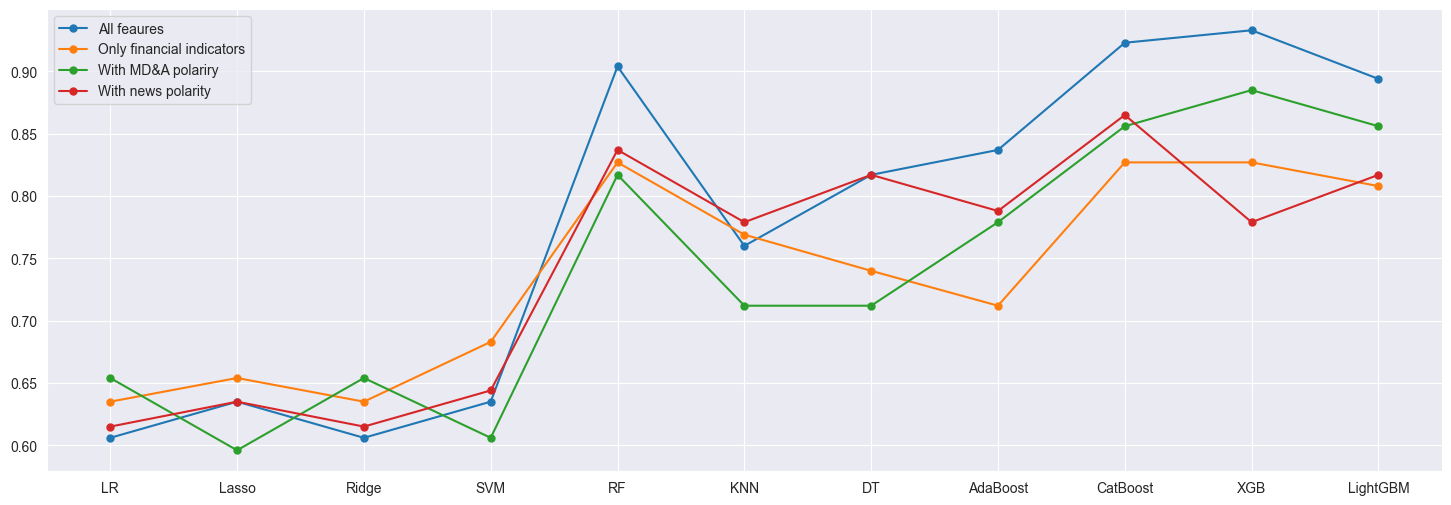

In [101]:
x = [
    'LR',
    'Lasso',
    'Ridge',
    'SVM',
    'RF',
    'KNN',
    'DT',
    'AdaBoost',
    'CatBoost',
    'XGB',
    'LightGBM'
]

fig, ax = plt.subplots(figsize=(18,6))

ax.plot(x, all_features, label='All feaures', marker ='.', markersize=10)
ax.plot(x, only_financials, label='Only financial indicators', marker ='.', markersize=10)
ax.plot(x, with_MDandA, label='With MD&A polariry', marker ='.', markersize=10)
ax.plot(x, with_news, label='With news polarity', marker ='.', markersize=10)
leg = ax.legend()
plt.savefig('filename.png', format='png', transparent=True)
plt.show()

In [103]:
class GridSearch(object):
    
    def __init__(self,X_train,y_train,model,hyperparameters):
        
        self.X_train = X_train
        self.y_train = y_train
        self.model = model
        self.hyperparameters = hyperparameters
        
    def GridSearch(self):
        # Create randomized search 3-fold cross validation
        cv = 3
        clf = GridSearchCV(self.model,
                                 self.hyperparameters,
                                 cv=cv,
                                 verbose=0,
                                 n_jobs=-1,
                                 )
        # Fit randomized search
        best_model = clf.fit(self.X_train, self.y_train)
        message = (best_model.best_score_, best_model.best_params_)
        print("Best: %f using %s" % (message))

        return best_model,best_model.best_params_
    
    def BestModelPredict(self,X_test):
        
        best_model,_ = self.GridSearch()
        pred = best_model.predict(X_test)
        return pred

In [104]:
params = {'depth':[6,7,8,9,10],
          'iterations':[100,250,500,100]
         }

In [105]:
cb = CatBoostClassifier()
cb_GridSearch = GridSearch(X_train,y_train,cb,params)

In [106]:
prediction_cb = cb_GridSearch.BestModelPredict(X_test)

Learning rate set to 0.01183
0:	learn: 0.6877587	total: 7.09ms	remaining: 3.54s
1:	learn: 0.6808253	total: 13.7ms	remaining: 3.41s
2:	learn: 0.6763796	total: 20.3ms	remaining: 3.37s
3:	learn: 0.6715193	total: 26.8ms	remaining: 3.32s
4:	learn: 0.6658351	total: 33ms	remaining: 3.27s
5:	learn: 0.6598572	total: 39.5ms	remaining: 3.25s
6:	learn: 0.6532078	total: 45.7ms	remaining: 3.22s
7:	learn: 0.6484755	total: 52ms	remaining: 3.2s
8:	learn: 0.6436810	total: 58.3ms	remaining: 3.18s
9:	learn: 0.6393231	total: 65ms	remaining: 3.18s
10:	learn: 0.6331993	total: 71.2ms	remaining: 3.17s
11:	learn: 0.6286742	total: 77.5ms	remaining: 3.15s
12:	learn: 0.6237575	total: 83.7ms	remaining: 3.14s
13:	learn: 0.6181127	total: 89.8ms	remaining: 3.12s
14:	learn: 0.6129961	total: 96.2ms	remaining: 3.11s
15:	learn: 0.6092583	total: 103ms	remaining: 3.1s
16:	learn: 0.6047794	total: 109ms	remaining: 3.1s
17:	learn: 0.6000473	total: 116ms	remaining: 3.09s
18:	learn: 0.5939709	total: 122ms	remaining: 3.1s
19:	lea

178:	learn: 0.2391455	total: 1.25s	remaining: 2.24s
179:	learn: 0.2380456	total: 1.26s	remaining: 2.23s
180:	learn: 0.2369888	total: 1.26s	remaining: 2.23s
181:	learn: 0.2363333	total: 1.27s	remaining: 2.22s
182:	learn: 0.2349677	total: 1.28s	remaining: 2.21s
183:	learn: 0.2340375	total: 1.28s	remaining: 2.21s
184:	learn: 0.2331565	total: 1.29s	remaining: 2.2s
185:	learn: 0.2322959	total: 1.3s	remaining: 2.19s
186:	learn: 0.2316941	total: 1.31s	remaining: 2.19s
187:	learn: 0.2303564	total: 1.31s	remaining: 2.18s
188:	learn: 0.2293734	total: 1.32s	remaining: 2.18s
189:	learn: 0.2282126	total: 1.33s	remaining: 2.17s
190:	learn: 0.2277386	total: 1.34s	remaining: 2.17s
191:	learn: 0.2267748	total: 1.34s	remaining: 2.16s
192:	learn: 0.2259737	total: 1.35s	remaining: 2.15s
193:	learn: 0.2247901	total: 1.36s	remaining: 2.14s
194:	learn: 0.2235393	total: 1.36s	remaining: 2.14s
195:	learn: 0.2228072	total: 1.37s	remaining: 2.13s
196:	learn: 0.2219998	total: 1.38s	remaining: 2.12s
197:	learn: 0.

344:	learn: 0.1258810	total: 2.26s	remaining: 1.02s
345:	learn: 0.1252554	total: 2.27s	remaining: 1.01s
346:	learn: 0.1250314	total: 2.27s	remaining: 1s
347:	learn: 0.1246267	total: 2.28s	remaining: 997ms
348:	learn: 0.1241914	total: 2.29s	remaining: 989ms
349:	learn: 0.1237408	total: 2.29s	remaining: 983ms
350:	learn: 0.1233177	total: 2.3s	remaining: 976ms
351:	learn: 0.1229406	total: 2.3s	remaining: 969ms
352:	learn: 0.1223986	total: 2.31s	remaining: 962ms
353:	learn: 0.1219243	total: 2.31s	remaining: 955ms
354:	learn: 0.1214026	total: 2.32s	remaining: 948ms
355:	learn: 0.1211666	total: 2.33s	remaining: 941ms
356:	learn: 0.1207224	total: 2.33s	remaining: 935ms
357:	learn: 0.1203586	total: 2.34s	remaining: 928ms
358:	learn: 0.1200680	total: 2.35s	remaining: 921ms
359:	learn: 0.1195647	total: 2.35s	remaining: 914ms
360:	learn: 0.1192290	total: 2.36s	remaining: 907ms
361:	learn: 0.1189298	total: 2.36s	remaining: 900ms
362:	learn: 0.1184688	total: 2.37s	remaining: 893ms
363:	learn: 0.118

In [107]:
print('Test set evaluation:\n')
print_evaluate(y_test, prediction_cb)
print('--------------------------------\n')

Test set evaluation:

accuracy:  0.923
precision:  0.885
recall:  0.958
f1: 0.92
balanced accuracy: 0.926
roc_auc: 0.926
--------------------------------



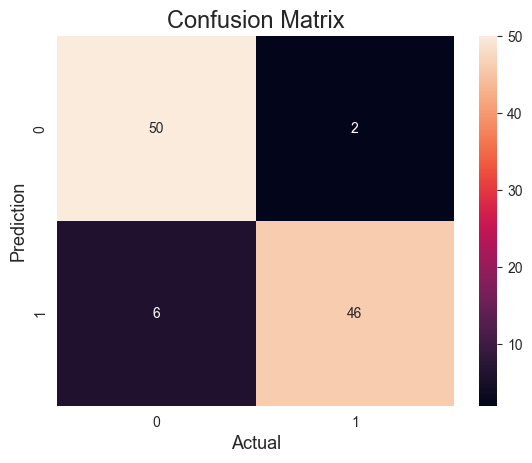

In [108]:
confusion_matrix = metrics.confusion_matrix(prediction_cb, y_test)
sns.heatmap(confusion_matrix,
            annot=True,
            fmt='g')
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

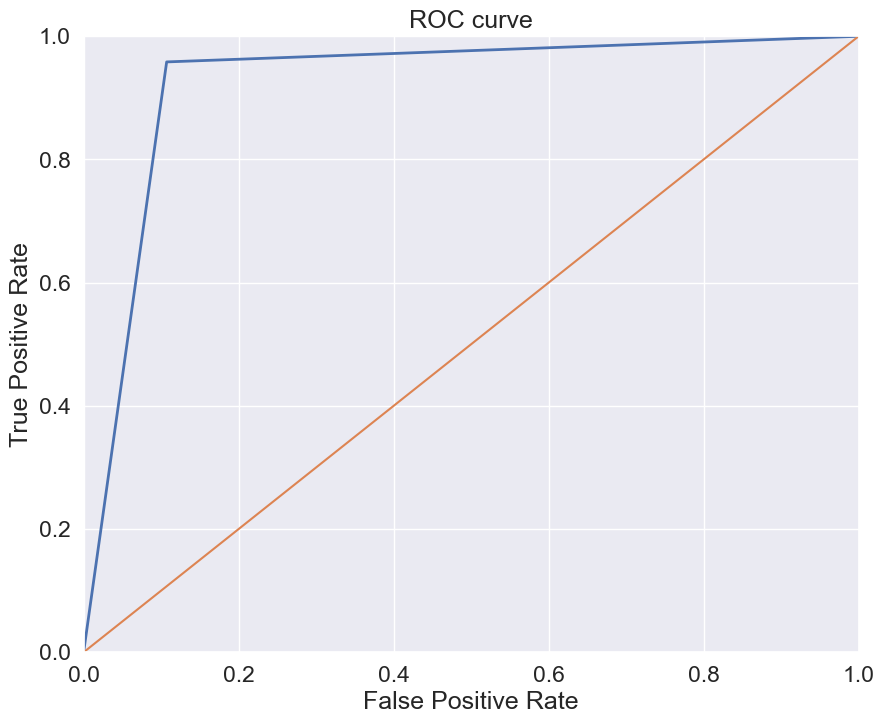

In [109]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")
plt.figure(figsize=(10, 8))
fpr, tpr, _ = metrics.roc_curve(y_test, prediction_cb)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

In [110]:
cb = CatBoostClassifier(depth=7, iterations=500)
cb.fit(X_train,y_train)

Learning rate set to 0.01183
0:	learn: 0.6877587	total: 7.27ms	remaining: 3.63s
1:	learn: 0.6808253	total: 13.4ms	remaining: 3.33s
2:	learn: 0.6763796	total: 18.8ms	remaining: 3.12s
3:	learn: 0.6715193	total: 25.1ms	remaining: 3.11s
4:	learn: 0.6658351	total: 30.3ms	remaining: 3s
5:	learn: 0.6598572	total: 35.8ms	remaining: 2.95s
6:	learn: 0.6532078	total: 41ms	remaining: 2.88s
7:	learn: 0.6484755	total: 46.1ms	remaining: 2.83s
8:	learn: 0.6436810	total: 51.3ms	remaining: 2.8s
9:	learn: 0.6393231	total: 56.2ms	remaining: 2.75s
10:	learn: 0.6331993	total: 61ms	remaining: 2.71s
11:	learn: 0.6286742	total: 66.5ms	remaining: 2.71s
12:	learn: 0.6237575	total: 71.5ms	remaining: 2.68s
13:	learn: 0.6181127	total: 76.5ms	remaining: 2.65s
14:	learn: 0.6129961	total: 81.5ms	remaining: 2.63s
15:	learn: 0.6092583	total: 86.7ms	remaining: 2.62s
16:	learn: 0.6047794	total: 91.8ms	remaining: 2.61s
17:	learn: 0.6000473	total: 96.8ms	remaining: 2.59s
18:	learn: 0.5939709	total: 103ms	remaining: 2.6s
19:

191:	learn: 0.2267748	total: 1.02s	remaining: 1.63s
192:	learn: 0.2259737	total: 1.02s	remaining: 1.63s
193:	learn: 0.2247901	total: 1.03s	remaining: 1.63s
194:	learn: 0.2235393	total: 1.04s	remaining: 1.62s
195:	learn: 0.2228072	total: 1.04s	remaining: 1.62s
196:	learn: 0.2219998	total: 1.05s	remaining: 1.61s
197:	learn: 0.2210110	total: 1.05s	remaining: 1.6s
198:	learn: 0.2204862	total: 1.06s	remaining: 1.6s
199:	learn: 0.2196224	total: 1.06s	remaining: 1.59s
200:	learn: 0.2188753	total: 1.07s	remaining: 1.59s
201:	learn: 0.2178218	total: 1.07s	remaining: 1.58s
202:	learn: 0.2168948	total: 1.08s	remaining: 1.58s
203:	learn: 0.2162866	total: 1.08s	remaining: 1.57s
204:	learn: 0.2153315	total: 1.09s	remaining: 1.56s
205:	learn: 0.2147110	total: 1.09s	remaining: 1.56s
206:	learn: 0.2136146	total: 1.1s	remaining: 1.55s
207:	learn: 0.2127851	total: 1.1s	remaining: 1.55s
208:	learn: 0.2117503	total: 1.11s	remaining: 1.54s
209:	learn: 0.2111121	total: 1.11s	remaining: 1.54s
210:	learn: 0.21

384:	learn: 0.1103792	total: 2.02s	remaining: 602ms
385:	learn: 0.1100390	total: 2.02s	remaining: 597ms
386:	learn: 0.1096586	total: 2.03s	remaining: 592ms
387:	learn: 0.1093389	total: 2.03s	remaining: 587ms
388:	learn: 0.1088948	total: 2.04s	remaining: 582ms
389:	learn: 0.1083440	total: 2.04s	remaining: 577ms
390:	learn: 0.1078768	total: 2.05s	remaining: 571ms
391:	learn: 0.1074695	total: 2.05s	remaining: 566ms
392:	learn: 0.1071121	total: 2.06s	remaining: 560ms
393:	learn: 0.1068629	total: 2.06s	remaining: 555ms
394:	learn: 0.1065226	total: 2.07s	remaining: 550ms
395:	learn: 0.1060443	total: 2.07s	remaining: 545ms
396:	learn: 0.1057061	total: 2.08s	remaining: 539ms
397:	learn: 0.1053773	total: 2.08s	remaining: 534ms
398:	learn: 0.1049423	total: 2.09s	remaining: 529ms
399:	learn: 0.1046888	total: 2.09s	remaining: 523ms
400:	learn: 0.1043725	total: 2.1s	remaining: 518ms
401:	learn: 0.1040593	total: 2.1s	remaining: 513ms
402:	learn: 0.1037197	total: 2.11s	remaining: 507ms
403:	learn: 0.

In [111]:
feature_scores = pd.Series(cb.feature_importances_, index=dataset.drop('FINANCIAL_DISTRESS',axis=1).columns).sort_values(ascending=False)
feature_scores

NewsOverall                                   8.050827
ROA                                           7.467839
polarity_MD&A                                 7.090797
EarningsPerShareBasic                         5.794911
Revenues                                      4.605724
D/A                                           4.602287
D/E                                           4.554730
subjectivity_MD&A                             4.504645
IncreaseDecreaseInAccountsPayable             4.353840
InterestExpense                               4.330558
Liabilities                                   4.231538
OperatingCashFlowRatio                        4.143924
D/EBIT                                        3.874088
RetainedEarningsAccumulatedDeficit            3.862842
NetCashProvidedByUsedInOperatingActivities    3.138877
InterestCoverageRatio                         3.041116
CashRatio                                     2.937188
CashAndCashEquivalentsAtCarryingValue         2.852145
OperatingI

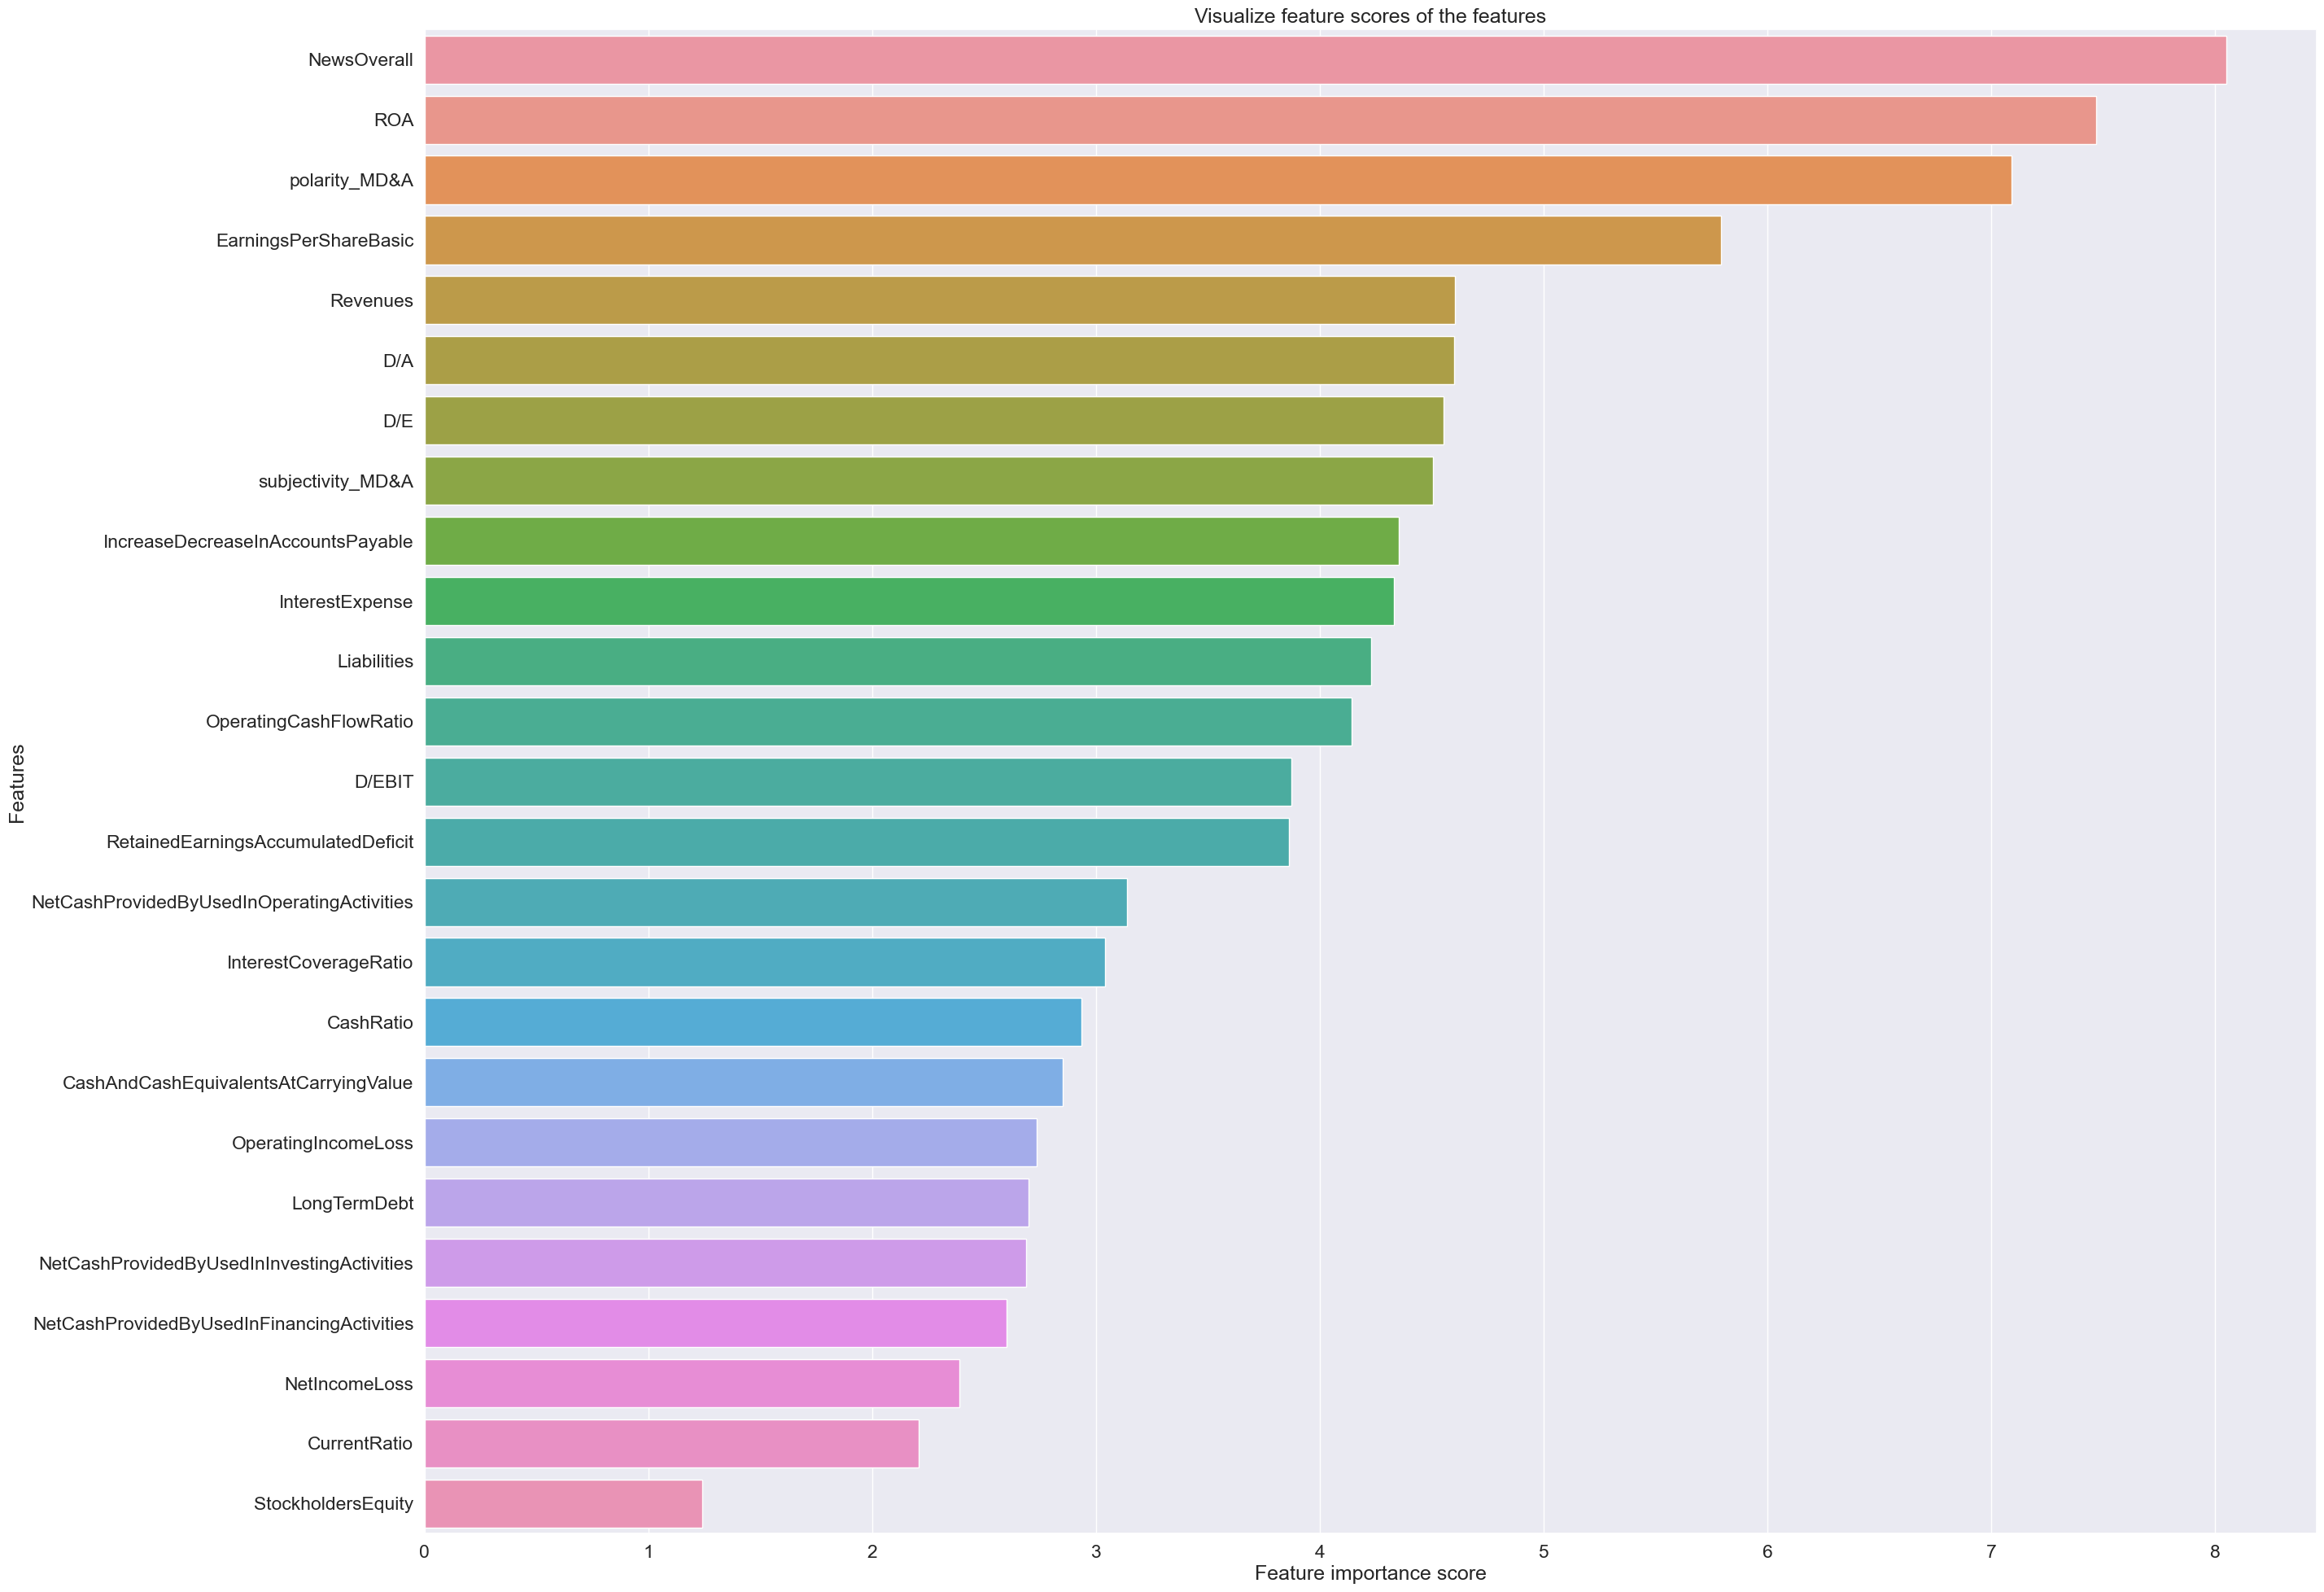

In [112]:
f, ax = plt.subplots(figsize=(30, 24))
ax = sns.barplot(x=feature_scores, y=feature_scores.index)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()